### Import modules

In [3]:

import pandas as pd
import numpy as np

#Image analysis
import cv2
import mahotas as mt

#UNIX and OS functionality
import os, glob


#Vizualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#sklearn models
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection as f_select
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report
import imblearn.over_sampling
import imblearn.under_sampling
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from sklearn.decomposition import PCA


from sklearn.dummy import DummyClassifier


%matplotlib inline

### Functions

In [362]:
def make_HUmoments(image_path):
    '''
    Hu Moments are used to characterize the outline 
    or “silhouette” of an object in an image.Use open cv2 to 
    convert the color image to a greyscale version and
    calcualte its 24 moments followed by flattening it out to 7.
    '''
    #read in the image
    img1 = cv2.imread(image_path)
    
    #Convert the image to a grayscale image
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    #Calculate moments from the image and flatten and reduce the moments to give HU moments
    img2_hum = cv2.HuMoments(cv2.moments(img2)).flatten()
    return img2_hum 

def image_colorfulness(image_path):
    # read in image
    image = cv2.imread(image_path)
    
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(image.astype("float"))

    # compute rg = R - G
    rg = np.absolute(R - G)

    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)

    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))

    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))

    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

def binary_ratio(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img2,127,255,cv2.THRESH_BINARY_INV)
    try:
        black, white = np.unique(np.ndarray.flatten(thresh), return_counts=True)[1]
    except:
        black = np.unique(np.ndarray.flatten(thresh), return_counts=True)[1]
    try:
        binary_ratio = white/(black+white)
    except:
        binary_ratio = 0
    return binary_ratio

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def make_edges(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_blur = cv2.GaussianBlur(img2,(3,3), 0)
    img3 = auto_canny(img2_blur)
    try:
        black, white = np.unique(np.ndarray.flatten(img3), return_counts=True)[1]
    except:
        black = np.unique(np.ndarray.flatten(img3), return_counts=True)[1]
    try:
        edges_ratio = white/(black+white)
    except:
        edges_ratio = 0
    return edges_ratio

def get_color_ratios(image_path):
    img1 = cv2.imread(image_path)
    mean = cv2.mean(img1)[:3]
    b_ratio, g_ratio, r_ratio = mean[0]/sum(mean), mean[1]/sum(mean), mean[2]/sum(mean)
    return b_ratio, g_ratio, r_ratio

def get_textures(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(img2)

    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

def best_F1_finder(lower, higher, model):
    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(lower,higher,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(model_val_labels, y_val))

    plt.plot(thresh_ps, f1_scores)
    plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
    plt.xlabel('P threshold')
    plt.ylabel('F1 score')

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))
    
def test_logistic(X_train, y_train, X_test, y_test, *args, **kwargs):
    lr = LogisticRegressionCV(solver = 'lbfgs', cv =10, max_iter = 2000) 
    lr.fit(X_train, y_train)
    print('Simple Logistic Regression(lr); Train F1: %.3f, Train AUC: %.3f' % \
          (f1_score(lr.predict(X_train), y_train), roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])))
    
    print('Simple Logistic Regression(lr); Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
    return confusion_matrix(y_test, lr.predict(X_test)), lr
      
def test_logistic_oversampling(X_train, y_train, X_test, y_test, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = a//b
    ROS = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:a,1:b*factor}, \
                                               random_state=42) 
    
    X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

    lr_os = LogisticRegressionCV(solver = 'lbfgs', cv =10 , max_iter = 2000) 
    lr_os.fit(X_tr_rs, y_tr_rs)

    print('Logistic Regression CV on Oversampled Train Data(lr_os); Train F1: %.3f, Train AUC: %.3f' % \
          (f1_score(lr_os.predict(X_train), y_train), roc_auc_score(y_train, lr_os.predict_proba(X_train)[:,1])))
    print('Logistic Regression CV on Oversampled Train Data(lr_os); Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr_os.predict(X_test), y_test), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))
    
    return confusion_matrix(y_test, lr_os.predict(X_test)), lr_os
    
def test_logistic_smote(X_train, y_train, X_test, y_test, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = a//b
    smote = imblearn.over_sampling.SMOTE(\
                                         ratio={0:a,1:b*factor}, \
                                         random_state = 42)

    X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train)

    lr_smote = LogisticRegressionCV(solver = 'lbfgs', cv =10 , max_iter = 2000) 
    lr_smote.fit(X_tr_smote, y_tr_smote)

    print('Logistic Regression on SMOTE Train Data(lr_smote); Train F1: %.3f, Train AUC: %.3f' % \
          (f1_score(lr_smote.predict(X_train), y_train), roc_auc_score(y_train, lr_smote.predict_proba(X_train)[:,1])))
    print('Logistic Regression on SMOTE Data(lr_smote); Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr_smote.predict(X_test), y_test), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))
    
    return confusion_matrix(y_test, lr_smote.predict(X_test)), lr_smote
    
def test_logistic_undersampling(X_train, y_train, X_test, y_test, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = b/a
    RUS = imblearn.under_sampling.RandomUnderSampler(\
                                         ratio={0:int(a*factor),1:b}, \
                                         random_state = 42)

    X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)

    lr_RUS = LogisticRegressionCV(solver = 'lbfgs', cv =10 , max_iter = 2000) 
    lr_RUS.fit(X_tr_RUS, y_tr_RUS)

    print('Logistic Regression on Undersampled Train Data(lr_RUS); Test F1: %.3f, Test AUC: %.3f' % \
         (f1_score(lr_RUS.predict(X_test), y_test), roc_auc_score(y_test, lr_RUS.predict_proba(X_test)[:,1])))
    return confusion_matrix(y_test, lr_RUS.predict(X_test)), lr_RUS
    
def test_logistic_weights(X_train, y_train, X_test, y_test, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = a//b
    
    lr_balanced = LogisticRegressionCV(class_weight='balanced',solver ='lbfgs', cv =10 , max_iter = 2000)
    lr_factorx = LogisticRegressionCV(class_weight={1 : factor, 0 : 1}, solver ='lbfgs', cv =10 , max_iter = 2000)

    lr_balanced.fit(X_train, y_train)
    print('Balanced class weights Logistic Regression(lr_balanced) Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr_balanced.predict(X_test), y_test), roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1])))
    
    lr_factorx.fit(X_train, y_train)
    print('3:1 class weights Logistic Regression(lr_factorx) Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr_factorx.predict(X_test), y_test), roc_auc_score(y_test, lr_factorx.predict_proba(X_test)[:,1])))
    return confusion_matrix(y_test, lr_factorx.predict(X_test)), confusion_matrix(y_test, lr_balanced.predict(X_test)), lr_balanced, lr_factorx

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def make_edges(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_blur = cv2.GaussianBlur(img2,(3,3), 0)
    img3 = auto_canny(img2_blur)
    try:
        black, white = np.unique(np.ndarray.flatten(img3), return_counts=True)[1]
    except:
        black = np.unique(np.ndarray.flatten(img3), return_counts=True)[1]
    try:
        edges_ratio = white/(black+white)
    except:
        edges_ratio = 0
    return edges_ratio

def make_edges_HU(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_blur = cv2.GaussianBlur(img2,(3,3), 0)
    img3 = auto_canny(img2_blur)
    
    #Calculate moments from the image and flatten and reduce the moments to give HU moments
    img3_edge_hum = cv2.HuMoments(cv2.moments(img3)).flatten()
    return img3_edge_hum
    
def get_edges_df(base_tile_dir):
    '''
    Creates a data frame with the 
    '''
    dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
    dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
    dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
    dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
    dataframe['image_row'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
    dataframe['image_col'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
    dataframe['edges_ratio'] = dataframe['path'].map(make_edges)
    
    return dataframe   

def get_edges_HU_df(base_tile_dir):
    '''
    Creates a data frame with the 
    '''
    dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
    dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
    dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
    dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
    dataframe['image_row'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
    dataframe['image_col'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
    dataframe['edges'] = dataframe['path'].map(make_edges_HU)
    dataframe[['edge1','edge2', 'edge3','edge4', 'edge5','edge6','edge7']] = pd.DataFrame(dataframe.edges.values.tolist(), index= dataframe.index)
    dataframe['y'] = dataframe.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})
    return dataframe

def get_moments_df(base_tile_dir):
    '''
    Creates a data frame with the 
    '''
    dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
    dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
    dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
    dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
    dataframe['image_row'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
    dataframe['image_col'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
    dataframe['image'] = dataframe['path'].map(make_HUmoments)
    dataframe[['moment1','moment2', 'moment3','moment4', 'moment5','moment6','moment7']] = pd.DataFrame(dataframe.image.values.tolist(), index= dataframe.index)
    return dataframe

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=200)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=['Not Tumor', 'Tumor'],
           yticklabels=['Not Tumor', 'Tumor']);
    ax.tick_params(labelsize = 14)
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
def get_final_df(base_tile_dir):
    '''
    Creates a data frame with the 
    base_tile_dir is the directory where you have stored the folders 
    containing the image data.
    make sure to `from glob import glob`,`import os` and `import opencv2` in addition
    numpy and pandas 
    '''
    dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
    dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
    dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
    dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
    dataframe['image_color'] = dataframe['path'].map(image_colorfulness)
    dataframe['edges_ratio'] = dataframe['path'].map(make_edges)
    dataframe['binary_ratio'] = dataframe['path'].map(binary_ratio)
    dataframe['moments'] = dataframe['path'].map(make_HUmoments)
    dataframe[['moment1','moment2', 'moment3','moment4', 'moment5','moment6','moment7']] = pd.DataFrame(dataframe.moments.values.tolist(), index= dataframe.index)
    dataframe[['moment1','moment2', 'moment3','moment4']] = np.log(dataframe[['moment1','moment2', 'moment3','moment4']])
    dataframe['color_ratio'] = dataframe['path'].map(get_color_ratios)
    dataframe[['b_ratio', 'g_ratio', 'r_ratio']] = dataframe['color_ratio'].apply(pd.Series)
    dataframe['textures'] = dataframe['path'].map(get_textures)
    dataframe[['texture1','texture2', 'texture3','texture4', 'texture5','texture6','texture7', 'texture8', 'texture9','texture10', 'texture11','texture12','texture13']] = dataframe['textures'].apply(pd.Series)
    dataframe = dataframe.drop(columns =['path', 'moments','moment5','moment6','moment7', 'color_ratio', 'textures'])
    dataframe['y'] = dataframe.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})
    return dataframe

In [5]:
base_tile_dir = './colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/'

### Testing code

In [211]:
img1 = cv2.imread('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

In [58]:
img1.shape

(150, 150, 3)

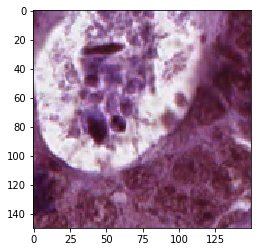

In [437]:
plt.imshow(img1)
plt.savefig('original.png', dpi =300);

In [5]:
img1.size

67500

In [213]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [8]:
img2.shape

(150, 150)

In [9]:
img2.size

22500

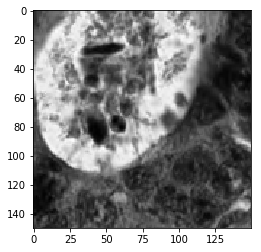

In [438]:
import matplotlib.cm as cm
plt.imshow(img2, cmap =cm.gray)
plt.savefig('greyscale.png', dpi =300);

In [66]:
blurred =cv2.GaussianBlur(img2,(3,3), 0)

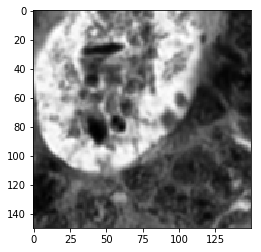

In [68]:
plt.imshow(blurred, cmap = cm.gray)

In [70]:
auto = auto_canny(blurred)

In [188]:
auto.shape

(150, 150)

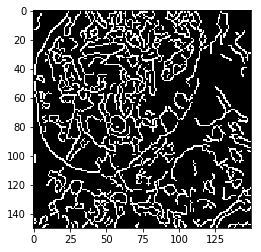

In [439]:
plt.imshow(auto, cmap =cm.gray)
plt.savefig('edges.png', dpi = 300)

In [185]:
mean_canny = cv2.mean(auto)

In [186]:
mean_canny

(49.742, 0.0, 0.0, 0.0)

In [24]:
np.unique(np.ndarray.flatten(auto), return_counts=True)[1]

array([18111,  4389])

In [18]:
black, white = np.unique(np.ndarray.flatten(auto), return_counts=True)[1]
edges_ratio = white/(black+white)

In [19]:
edges_ratio

0.19506666666666667

In [29]:
make_edges('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

0.19506666666666667

In [60]:
make_edges_HU('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

array([ 3.18592811e-03,  1.86786835e-07,  1.32015147e-10,  3.62728523e-10,
        6.90718851e-20,  8.97933429e-14, -3.91086405e-20])

### Make edges ratio

In [17]:
print(os.getcwd())

/Users/Swami/ds/metis/metisgh/Project-McNulty/Colorectal_cancer


In [6]:
df_edges_r = get_edges_df(base_tile_dir)

In [7]:
df_edges_r.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,edges_ratio
2025,./colorectal-histology-mnist/kather_texture_20...,LYMPHO,04,14EB0_CRC-Prim-HE-05_023.tif,451,451,0.254533
4674,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,12CA3_CRC-Prim-HE-06_005.tif,3901,3301,0.000000
2585,./colorectal-histology-mnist/kather_texture_20...,DEBRIS,05,11DE1_CRC-Prim-HE-08_023.tif,1,1051,0.128311
1861,./colorectal-histology-mnist/kather_texture_20...,COMPLEX,03,776F_CRC-Prim-HE-03_002.tif,301,901,0.220533
2099,./colorectal-histology-mnist/kather_texture_20...,LYMPHO,04,17BFA_CRC-Prim-HE-09_013.tif,1,1,0.265956


In [8]:
df_edges_r['y'] = df_edges_r.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})

In [9]:
df_edges_r.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,edges_ratio,y
3541,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,17194_CRC-Prim-HE-07_001_copy.tif,1201,151,0.149422,0
1564,./colorectal-histology-mnist/kather_texture_20...,COMPLEX,03,17745_CRC-Prim-HE-05_009a.tif,1,1051,0.111600,0
4270,./colorectal-histology-mnist/kather_texture_20...,ADIPOSE,07,16107_CRC-Prim-HE-05_032.tif,1201,2701,0.025200,0
3509,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,168FA_CRC-Prim-HE-06_001.tif,1951,301,0.148178,0
3134,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,10327_CRC-Prim-HE-05.tif,901,901,0.172533,0


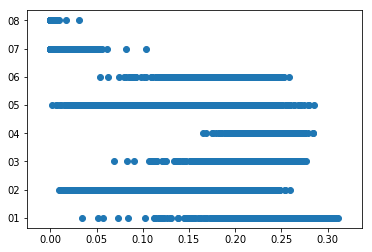

In [10]:
plt.scatter(df_edges_r['edges_ratio'], df_edges_r['cell_type_idx']);

### Make Edges HU

In [62]:
df_edges = get_edges_HU_df(base_tile_dir)

In [63]:
df_edges.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,edges,edge1,edge2,edge3,edge4,edge5,edge6,edge7
2667,./colorectal-histology-mnist/kather_texture_20...,DEBRIS,05,142DE_CRC-Prim-HE-05_031.tif,451,301,"[0.005245794325502642, 3.7753336103956667e-06,...",0.005246,3.775334e-06,4.817253e-08,2.598221e-09,-1.209015e-17,-4.462444e-12,-2.643430e-17
480,./colorectal-histology-mnist/kather_texture_20...,TUMOR,01,66CF_CRC-Prim-HE-07_022.tif,451,1,"[0.0026468471920926776, 6.22917593781444e-09, ...",0.002647,6.229176e-09,5.689540e-11,2.870959e-11,2.194472e-22,-6.428209e-16,1.139383e-21
3926,./colorectal-histology-mnist/kather_texture_20...,ADIPOSE,07,121C0_CRC-Prim-HE-05_032.tif,601,751,"[0.009302440895038358, 7.076631315104129e-05, ...",0.009302,7.076631e-05,2.447797e-07,1.400050e-07,2.540649e-14,1.013676e-09,5.124312e-15
4801,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,13C8E_CRC-Prim-HE-06_005.tif,4201,2251,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3819,./colorectal-histology-mnist/kather_texture_20...,ADIPOSE,07,10D5C_CRC-Prim-HE-03_012.tif,4051,1501,"[0.023694557471379312, 0.00011541321932136046,...",0.023695,1.154132e-04,1.729542e-05,6.520344e-06,6.330524e-11,7.088514e-09,2.805242e-11


In [72]:
df_edges['y'] = df_edges.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})

In [81]:
df_edges.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,edges,edge1,edge2,edge3,edge4,edge5,edge6,edge7,y
3312,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,136F7_CRC-Prim-HE-06_032.tif,751,451,"[0.004201735329879917, 1.866280589888884e-08, ...",0.004202,1.866281e-08,3.276909e-09,3.247621e-10,1.564931e-19,4.196316e-14,-2.962316e-19,0
1358,./colorectal-histology-mnist/kather_texture_20...,COMPLEX,03,12601_CRC-Prim-HE-01_030.tif,1,301,"[0.0026743746047235596, 6.898859038727014e-09,...",0.002674,6.898859e-09,2.319933e-12,1.993082e-11,-1.289366e-22,-1.619355e-15,-4.174807e-23,0
3399,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,14F1F_CRC-Prim-HE-06_035.tif,601,151,"[0.0029037912032865943, 3.035206815098296e-08,...",0.002904,3.035207e-08,1.065729e-10,2.082644e-11,7.626385e-22,3.589597e-15,6.173207e-22,0
492,./colorectal-histology-mnist/kather_texture_20...,TUMOR,01,6CEC_CRC-Prim-HE-04_032.tif,451,151,"[0.0032042238014565877, 8.991037815440282e-09,...",0.003204,8.991038e-09,1.942268e-10,1.379782e-10,-1.796652e-20,1.070793e-14,-1.368957e-20,1
2925,./colorectal-histology-mnist/kather_texture_20...,DEBRIS,05,447_CRC-Prim-HE-08_024.tif,1201,301,"[0.00393811595246085, 5.215228157802534e-07, 1...",0.003938,5.215228e-07,1.794896e-09,1.230618e-10,4.080953e-20,1.655213e-14,-4.098395e-20,0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


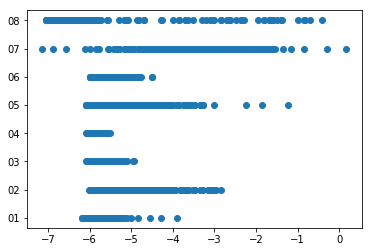

In [235]:
plt.scatter(np.log(df_edges['edge1']), df_edges['cell_type_idx']);

In [85]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
path             5000 non-null object
cell_type        5000 non-null object
cell_type_idx    5000 non-null object
image_name       5000 non-null object
image_row        5000 non-null object
image_col        5000 non-null object
edges            5000 non-null object
edge1            5000 non-null float64
edge2            5000 non-null float64
edge3            5000 non-null float64
edge4            5000 non-null float64
edge5            5000 non-null float64
edge6            5000 non-null float64
edge7            5000 non-null float64
y                5000 non-null int64
dtypes: float64(7), int64(1), object(7)
memory usage: 586.0+ KB


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


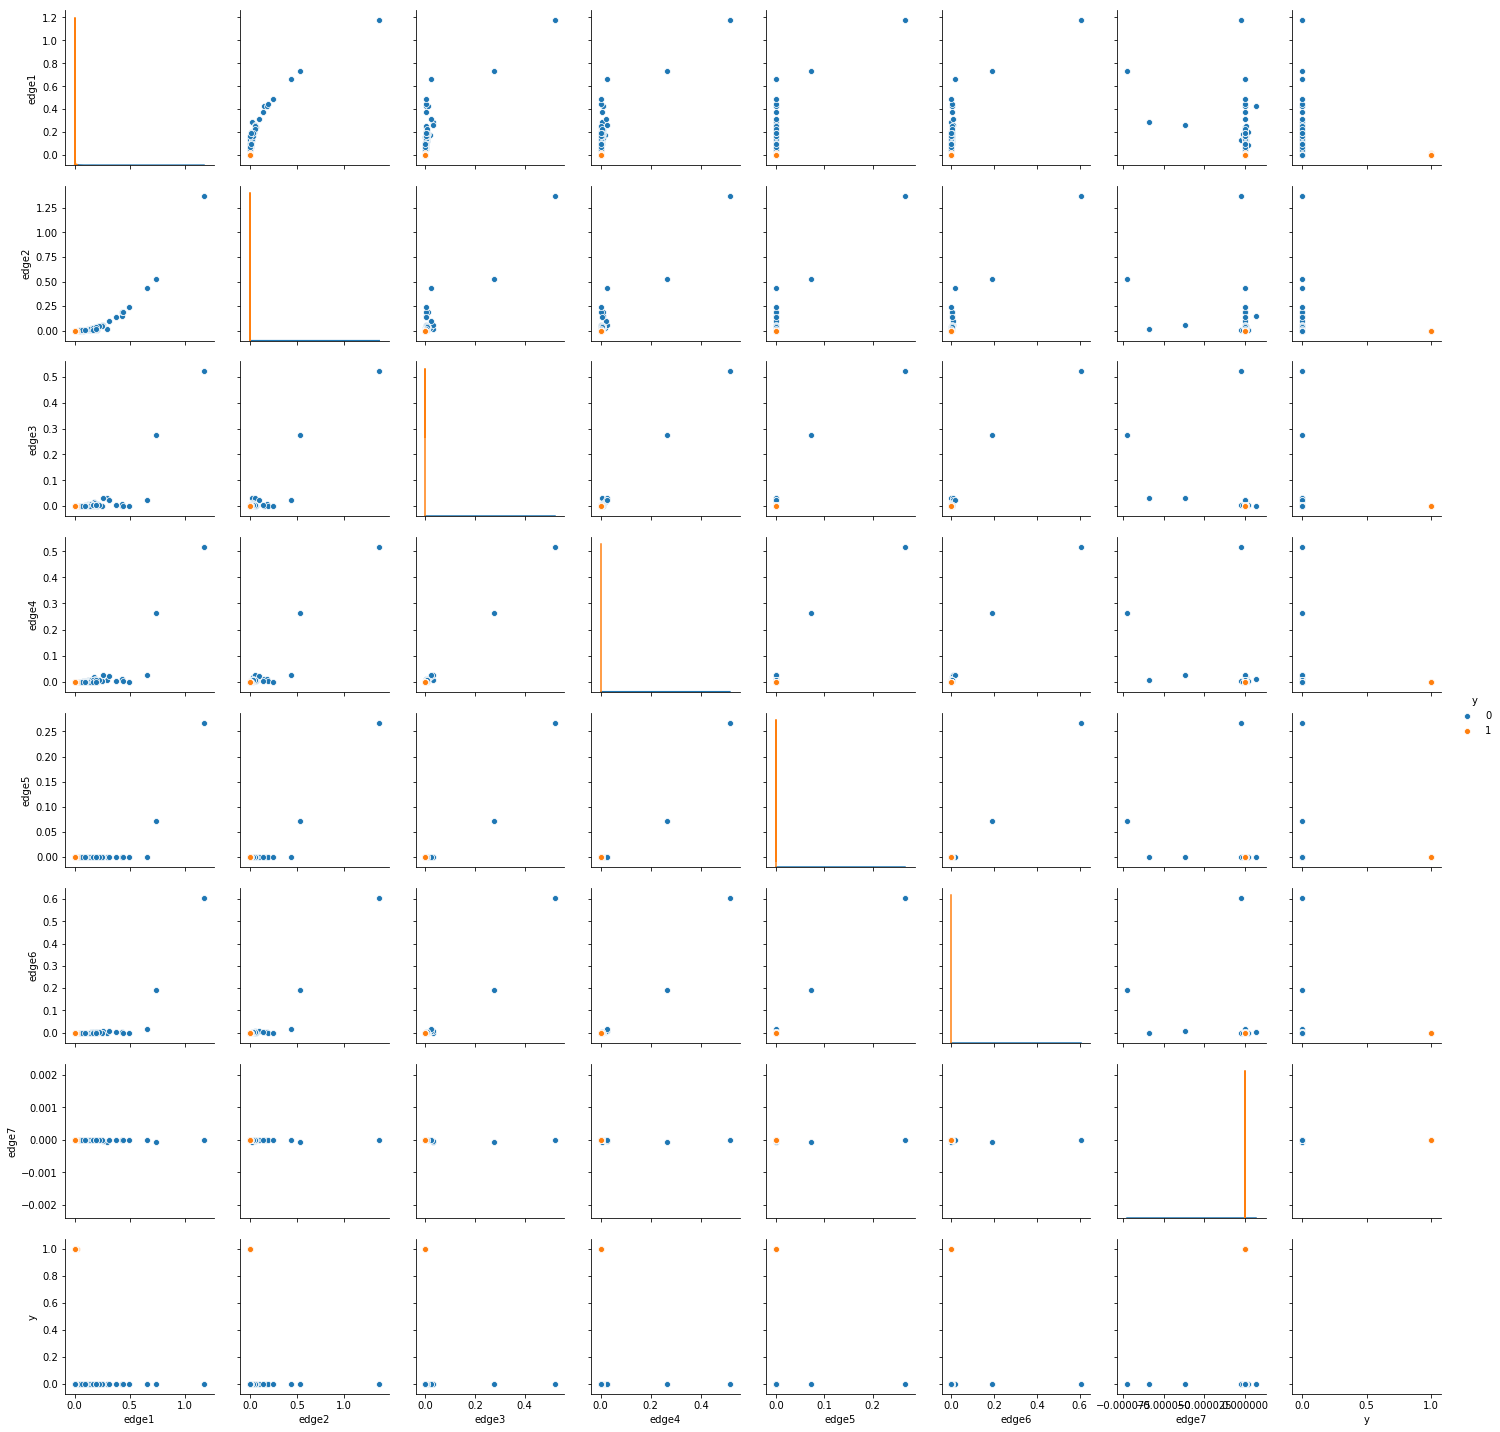

In [77]:
sns.pairplot(df_edges.loc[:,'edge1':'y'], hue = 'y')

In [86]:
df_test1 = df_edges.loc[:,'edge1':'y']

In [87]:
df_test1.head(5)

,edge1,edge2,edge3,edge4,edge5,edge6,edge7,y
0,0.002370,7.392079e-09,6.499816e-12,2.383517e-12,-9.113062e-24,-9.355626e-17,-2.228668e-24,1
1,0.002459,3.294811e-09,7.865250e-11,8.150891e-12,-1.750945e-23,3.744316e-17,2.056341e-22,1
2,0.002573,4.319257e-08,4.924336e-11,3.261452e-11,1.236814e-21,4.479975e-15,4.226754e-22,1
3,0.002518,1.258172e-08,2.789768e-12,1.851719e-11,-1.323722e-22,1.027990e-15,1.380844e-23,1
4,0.002521,3.626768e-08,6.529844e-11,2.302360e-11,-8.823315e-22,-4.379450e-15,-1.357403e-22,1


In [100]:
df_test1.columns

Index(['edge1', 'edge2', 'edge3', 'edge4', 'edge5', 'edge6', 'edge7'], dtype='object')

In [99]:
df_test1 = df_test1.drop(columns =['y'])

In [83]:
from sklearn.preprocessing import StandardScaler
X =  df_edges.loc[:,'edge1':'edge7']
y = df_edges['y']

ssX = StandardScaler()
X_scaled = ssX.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = ['edge1', 'edge2', 'edge3', 'edge4', 'edge5', 'edge6',
       'edge7'])

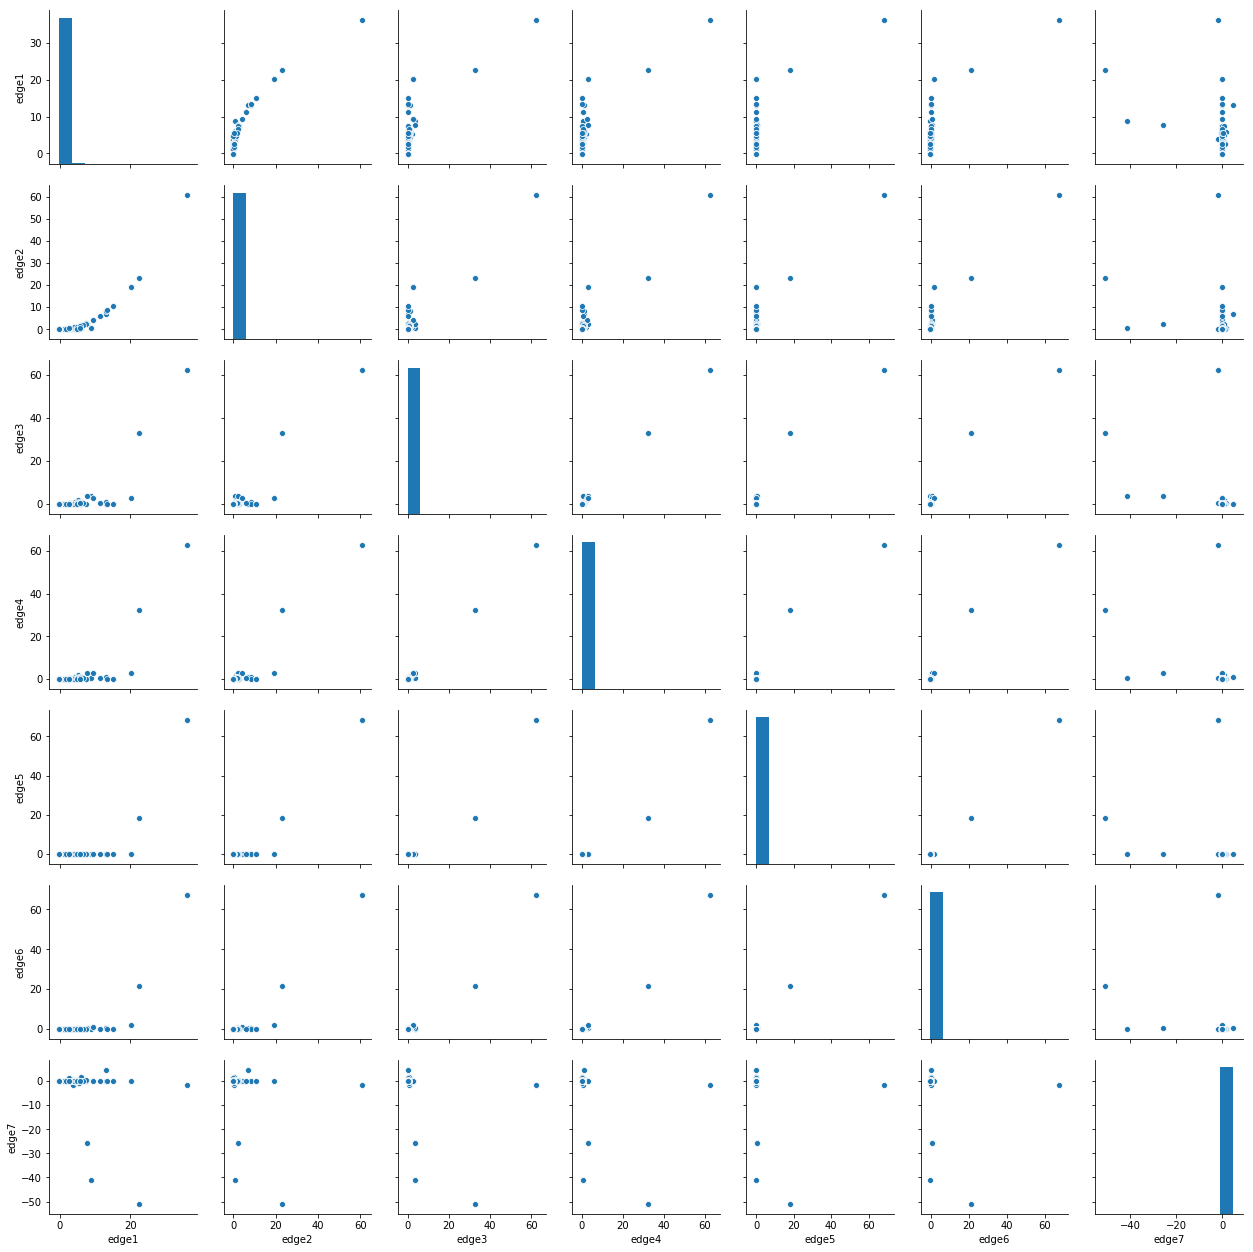

In [84]:
sns.pairplot(X_scaled)

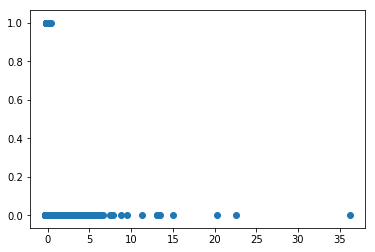

In [89]:
plt.scatter(X_scaled['edge1'], y);

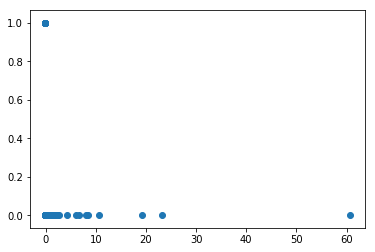

In [90]:
plt.scatter(X_scaled['edge2'], y);

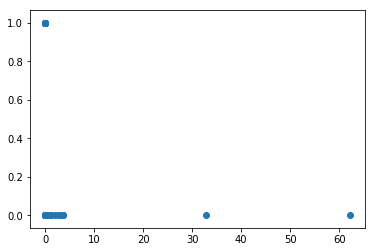

In [91]:
plt.scatter(X_scaled['edge3'], y);

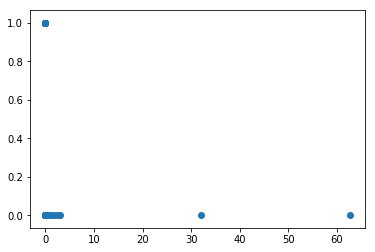

In [92]:
plt.scatter(X_scaled['edge4'], y);

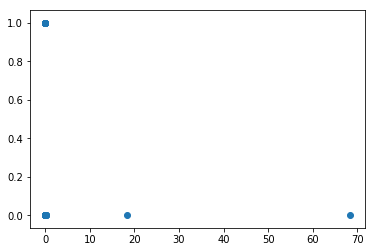

In [93]:
plt.scatter(X_scaled['edge5'], y);

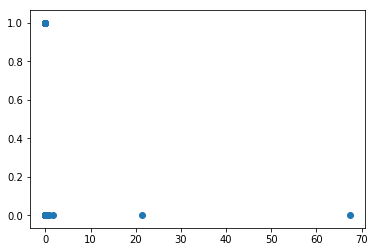

In [94]:
plt.scatter(X_scaled['edge6'], y);

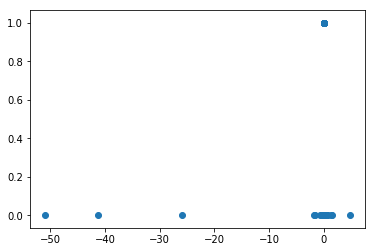

In [95]:
plt.scatter(X_scaled['edge7'], y);

In [110]:
est=LogisticRegression(solver ='lbfgs')
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[] # will be the list of all significant columns' p-values

for feature in X_scaled.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X_scaled[[feature]],df_edges_r.y) # univariate regression for feature selection ; gets f-value and p-value scores
    print(pval)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
df_new_trans=X_scaled[sig_columns]

cross_val_score(est,df_new_trans,df_edges_r.y,cv=5,scoring='accuracy').mean()

(array([25.14513623]), array([5.50121568e-07]))
(array([1.24485172]), array([0.26459169]))
(array([0.4887364]), array([0.48452404]))
(array([0.43953645]), array([0.50737685]))
(array([0.21756177]), array([0.64092437]))
(array([0.25930068]), array([0.61062349]))
(array([0.35829398]), array([0.54948237]))


0.875

In [111]:
sig_columns

['edge1']

### Modelling using standard scalar

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [116]:
X_train.head()

,edge1,edge2,edge3,edge4,edge5,edge6,edge7
1840,0.002579,1.306915e-08,3.475567e-12,3.509438e-12,5.300402e-25,5.662588e-17,-1.224511e-23
2115,0.002856,4.236227e-09,5.227751e-11,1.012822e-12,7.314633e-24,5.744389e-17,9.002683e-25
4437,0.001470,2.910051e-09,4.321772e-10,5.257696e-12,1.299131e-22,-2.834340e-16,2.143255e-22
1146,0.003250,1.069790e-07,1.244538e-10,8.603368e-11,-3.319846e-21,-1.361992e-14,8.260219e-21
2486,0.003014,1.414633e-09,6.048103e-11,1.445458e-11,4.120834e-22,-4.805965e-16,1.133307e-22


In [128]:
test_logistic(X_train, y_train, X_test, y_test)

Simple Logistic Regression(lr); Test F1: 0.000, Test AUC: 0.690


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


array([[1290,    0],
       [ 210,    0]])

In [129]:
test_logistic_oversampling(X_train, y_train, X_test, y_test)

Logistic Regression on Oversampled Train Data(lr_os); Test F1: 0.000, Test AUC: 0.690


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


array([[1290,    0],
       [ 210,    0]])

In [130]:
test_logistic_smote(X_train, y_train, X_test, y_test)

Logistic Regression on SMOTE Train Data(lr_smote); Test F1: 0.000, Test AUC: 0.690


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


array([[1290,    0],
       [ 210,    0]])

In [131]:
test_logistic_undersampling(X_train, y_train, X_test, y_test)

Logistic Regression on Undersampled Train Data(lr_RUS); Test F1: 0.288, Test AUC: 0.690


array([[ 274, 1016],
       [   4,  206]])

In [136]:
test_logistic_weights(X_train, y_train, X_test, y_test)

Balanced class weights Logistic Regression(lr_balanced) Test F1: 0.290, Test AUC: 0.690
3:1 class weights Logistic Regression(lr_factorx) Test F1: 0.000, Test AUC: 0.690


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(array([[1290,    0],
        [ 210,    0]]), array([[ 284, 1006],
        [   4,  206]]))

### log transform

In [161]:
X_log = np.log2(X)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log2
  """Entry point for launching an IPython kernel.


In [162]:
X_log.head()

,edge1,edge2,edge3,edge4,edge5,edge6,edge7
0,-8.720761,-27.011373,-37.162738,-38.610045,NaN,NaN,NaN
1,-8.667647,-28.177157,-33.565716,-36.836179,NaN,-54.568075,-72.042338
2,-8.602357,-24.464642,-34.241280,-34.835695,-69.453861,-47.665431,-71.002868
3,-8.633406,-26.244095,-38.382992,-35.652344,NaN,-49.789096,-75.938796
4,-8.631970,-24.716740,-33.834161,-35.338096,NaN,NaN,NaN


In [163]:
X_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
edge1    5000 non-null float64
edge2    5000 non-null float64
edge3    5000 non-null float64
edge4    5000 non-null float64
edge5    2965 non-null float64
edge6    2850 non-null float64
edge7    2736 non-null float64
dtypes: float64(7)
memory usage: 273.5 KB


In [159]:
#X_log = X_log.replace('-inf', 0, inplace = True)

AttributeError: 'NoneType' object has no attribute 'replace'

In [164]:
X_log.describe()

,edge1,edge2,edge3,edge4,edge5,edge6,edge7
count,5000.000000,5000.000000,5000.000000,5000.000000,2965.000000,2850.000000,2736.000000
mean,-inf,-inf,-inf,-inf,-inf,-inf,-inf
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,-8.583486,-28.064855,-35.912951,-37.292626,-76.647159,-53.844011,-77.306045
50%,-8.336750,-25.233122,-32.941682,-34.333609,-69.247622,-48.114732,-70.589118
75%,-7.701186,-21.349796,-28.866682,-30.029073,-58.821333,-40.063244,-62.242060
max,0.231005,0.455516,-0.942471,-0.953624,-1.901671,-0.725869,-17.180308


### Test binary

In [150]:
img1 = cv2.imread('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

In [151]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [152]:
ret,thresh = cv2.threshold(img2,127,255,cv2.THRESH_BINARY)
black, white = np.unique(np.ndarray.flatten(thresh), return_counts=True)[1]
binary_ratio = white/(black+white)

In [153]:
binary_ratio

0.3612444444444444

In [169]:
ret,thresh1 = cv2.threshold(img2,127,255,cv2.THRESH_BINARY_INV)
black, white = np.unique(np.ndarray.flatten(thresh1), return_counts=True)[1]
binary_ratio1 = white/(black+white)

In [170]:
binary_ratio1

0.6387555555555555

In [11]:
def binary_ratio(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img2,127,255,cv2.THRESH_BINARY_INV)
    black, white = np.unique(np.ndarray.flatten(thresh), return_counts=True)[1]
    binary_ratio = white/(black+white)
    return binary_ratio

In [12]:
binary_ratio('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

0.6387555555555555

In [183]:
ret,thresh2 = cv2.threshold(img2,127,255,cv2.THRESH_TOZERO)
#black, white = 
np.unique(np.ndarray.flatten(thresh2), return_counts=True)
#binary_ratio2 = white/(black+white)
#binary_ratio2
a = thresh2

In [206]:
ssX = StandardScaler()
img_scaled = ssX.fit_transform(thresh2)
#X_scaled = pd.DataFrame(X_scaled, columns = ['moment1', 'moment2', 'moment3', 'moment4', 'moment5', 'moment6',
       #'moment7'])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [207]:
img_scaled.shape

(150, 150)

In [210]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(img_scaled)
pcafeatures_train = pca.transform(img_scaled)
print(pca.explained_variance_ratio_)

[0.28705063 0.16237831 0.14209326 0.06252459]


In [209]:
pcafeatures_train.shape

(150, 3)

In [211]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(thresh2)
pcafeatures_train = pca.transform(thresh2)
print(pca.explained_variance_ratio_)

[0.35911516 0.1748441  0.15348177 0.04451826]


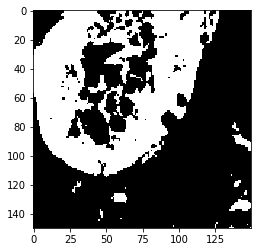

In [440]:
plt.imshow(thresh, cmap =cm.gray);
plt.savefig('binary.png', dpi  = 300)

### Color

lets try color ratios or colorfulness index

In [ ]:
mean = cv2.mean(img1)[:3]

In [182]:
mean

(143.8664888888889, 102.10168888888889, 133.66795555555555)

In [ ]:
mean = mean[:3]

In [180]:
mean

(143.8664888888889, 102.10168888888889, 133.66795555555555)

In [178]:
b_ratio, g_ratio, r_ratio = mean[0]/sum(mean), mean[1]/sum(mean), mean[2]/sum(mean)

In [179]:
b_ratio, g_ratio, r_ratio

(0.37895889315301107, 0.26894618273661575, 0.3520949241103733)

In [183]:
def get_color_ratios(image_path):
    img1 = cv2.imread(image_path)
    mean = cv2.mean(img1)[:3]
    b_ratio, g_ratio, r_ratio = mean[0]/sum(mean), mean[1]/sum(mean), mean[2]/sum(mean)
    return b_ratio, g_ratio, r_ratio

In [190]:
a = get_color_ratios('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

In [197]:
a = np.asarray(a)
a
a.values.tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [198]:
dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
dataframe['image_row'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
dataframe['image_col'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
dataframe['image_color'] = dataframe['path'].map(image_colorfulness)
dataframe['edges_ratio'] = dataframe['path'].map(make_edges)
dataframe['binary_ratio'] = dataframe['path'].map(binary_ratio)
dataframe['color_ratio'] = dataframe['path'].map(get_color_ratios)
dataframe[['b_ratio', 'g_ratio', 'r_ratio']] = dataframe['color_ratio'].apply(pd.Series)
dataframe['y'] = dataframe.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})
#dataframe[['edge1','edge2', 'edge3','edge4', 'edge5','edge6','edge7']] = pd.DataFrame(dataframe.edges.values.tolist(), index= dataframe.index)
#return dataframe   

In [199]:
dataframe.sample(8)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image_color,edges_ratio,binary_ratio,color_ratio,b_ratio,g_ratio,r_ratio,y
2615,./colorectal-histology-mnist/kather_texture_20...,DEBRIS,05,12C12_CRC-Prim-HE-08_021.tif,1501,451,47.350523,0.129022,0.329200,"(0.3279765280489453, 0.2853339848533653, 0.386...",0.327977,0.285334,0.386689,0
2418,./colorectal-histology-mnist/kather_texture_20...,LYMPHO,04,CE39_CRC-Prim-HE-01b.tif,601,301,39.160154,0.214578,0.859289,"(0.36902253729450957, 0.20640497510822534, 0.4...",0.369023,0.206405,0.424572,0
4174,./colorectal-histology-mnist/kather_texture_20...,ADIPOSE,07,1502D_CRC-Prim-HE-07.tif,1,3751,28.393440,0.029689,0.060311,"(0.33096605403110935, 0.3224535505074563, 0.34...",0.330966,0.322454,0.346580,0
1047,./colorectal-histology-mnist/kather_texture_20...,STROMA,02,1300F_CRC-Prim-HE-09_017.tif,1,301,39.594500,0.097733,0.809733,"(0.34360403652553595, 0.22211783952397313, 0.4...",0.343604,0.222118,0.434278,0
4764,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,13932_CRC-Prim-HE-06_005.tif,601,7201,2.299637,0.000000,0.000000,"(0.33283096909789756, 0.33434330153466835, 0.3...",0.332831,0.334343,0.332826,0
3525,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,16C7_CRC-Prim-HE-09_001.tif,1351,601,31.287331,0.154178,0.448356,"(0.36727847455062623, 0.27559586072233566, 0.3...",0.367278,0.275596,0.357126,0
525,./colorectal-histology-mnist/kather_texture_20...,TUMOR,01,7AC8_CRC-Prim-HE-09_010.tif,151,751,32.222940,0.305156,0.948444,"(0.41781464850191535, 0.20335051255257047, 0.3...",0.417815,0.203351,0.378835,1
736,./colorectal-histology-mnist/kather_texture_20...,STROMA,02,10C4A_CRC-Prim-HE-07_014.tif,1,2251,58.300476,0.117156,0.779867,"(0.30691424851390503, 0.21800202994961523, 0.4...",0.306914,0.218002,0.475084,0


In [200]:
dataframe.groupby('cell_type').mean()

,image_color,edges_ratio,binary_ratio,b_ratio,g_ratio,r_ratio,y
cell_type,,,,,,,
ADIPOSE,13.819914,0.019328,0.022735,0.335270,0.327396,0.337335,0
COMPLEX,44.212923,0.220235,0.760909,0.340364,0.218537,0.441099,0
DEBRIS,43.142938,0.134478,0.433980,0.321382,0.260891,0.417727,0
EMPTY,2.793015,0.000382,0.000780,0.333313,0.333657,0.333031,0
LYMPHO,37.121886,0.236181,0.851858,0.379977,0.214241,0.405782,0
MUCOSA,35.353453,0.185962,0.623963,0.363501,0.250179,0.386320,0
STROMA,47.249169,0.143861,0.640443,0.323546,0.232852,0.443602,0
TUMOR,36.388780,0.236683,0.872034,0.376096,0.212010,0.411894,1


In [201]:
dataframe.groupby('y').mean()

,image_color,edges_ratio,binary_ratio,b_ratio,g_ratio,r_ratio
y,,,,,,
0,31.956185,0.134347,0.476381,0.342479,0.262536,0.394985
1,36.388780,0.236683,0.872034,0.376096,0.212010,0.411894


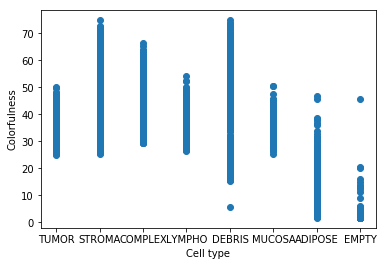

In [31]:
plt.scatter(dataframe.cell_type, dataframe.image_color);
plt.xlabel('Cell type');
plt.ylabel('Colorfulness');

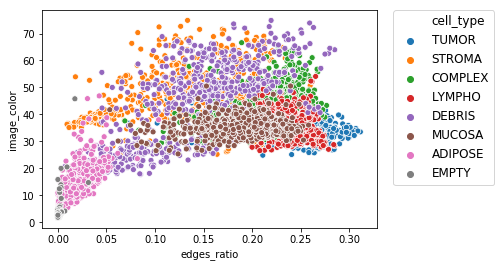

In [30]:
sns.scatterplot('edges_ratio', 'image_color', data = dataframe, hue ='cell_type', alpha = 1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize =12);

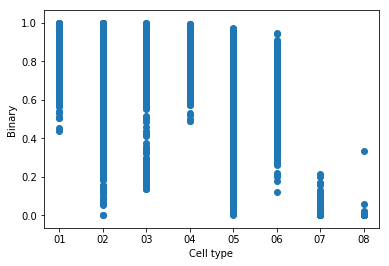

In [20]:
plt.scatter(dataframe.cell_type_idx, dataframe.binary_ratio);
plt.xlabel('Cell type');
plt.ylabel('Binary');

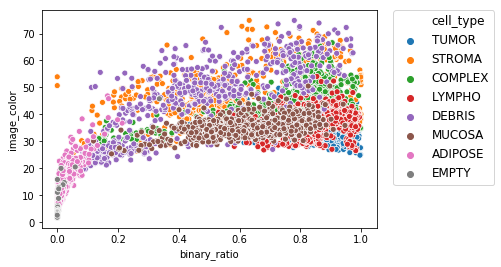

In [32]:
#sns.scatterplot('binary_ratio', 'image_color', data = dataframe, hue ='y');
sns.scatterplot('binary_ratio', 'image_color', data = dataframe, hue ='cell_type', alpha = 1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize =12);

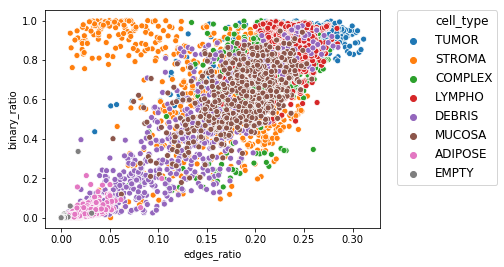

In [33]:
#sns.scatterplot('edges_ratio', 'binary_ratio', data = dataframe, hue ='y');
sns.scatterplot('edges_ratio', 'binary_ratio', data = dataframe, hue ='cell_type', alpha = 1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize =12);

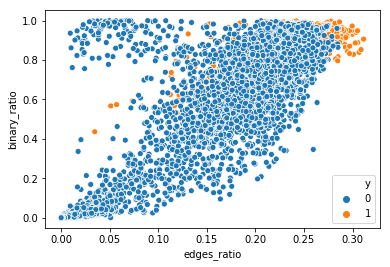

In [28]:
sns.scatterplot('edges_ratio', 'binary_ratio','y', data = dataframe);

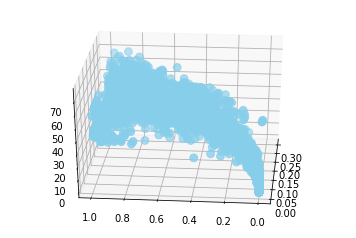

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataframe['edges_ratio'], dataframe['binary_ratio'], dataframe['image_color'], c='skyblue', s=60)
ax.view_init(30, 185)

In [53]:
df_test = dataframe[['edges_ratio', 'binary_ratio', 'image_color', 'cell_type']]

In [54]:
df_test.head()

,edges_ratio,binary_ratio,image_color,cell_type
0,0.271778,0.930133,37.381346,TUMOR
1,0.263956,0.983600,25.774205,TUMOR
2,0.240622,0.901333,38.188592,TUMOR
3,0.255111,0.958400,43.204986,TUMOR
4,0.253600,0.900356,34.589645,TUMOR


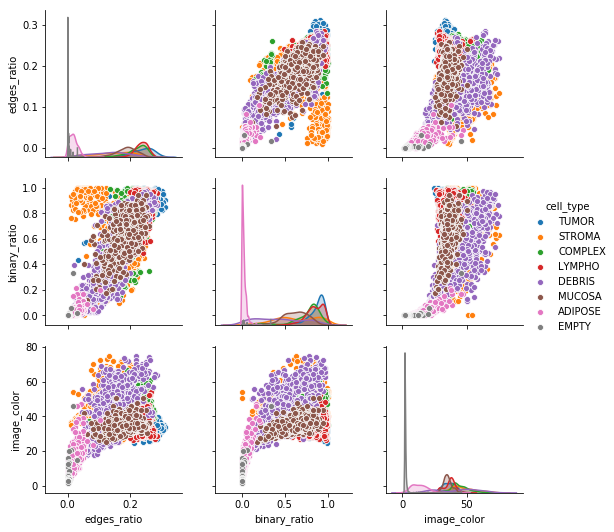

In [55]:
sns.pairplot(df_test, hue = 'cell_type');

### Haralicks textures

In [229]:
def get_textures(image_path):
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(img2)

    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

In [214]:
textures = mt.features.haralick(img2)

In [215]:
textures

array([[ 1.70010360e-04,  2.48223400e+02,  9.67855689e-01,
         3.86107823e+03,  1.11480760e-01,  2.33151365e+02,
         1.51960895e+04,  8.63311525e+00,  1.30193269e+01,
         1.54943735e-04,  4.95099179e+00, -2.99653785e-01,
         9.94904591e-01],
       [ 1.40730767e-04,  3.87486825e+02,  9.49946111e-01,
         3.87069652e+03,  9.20312613e-02,  2.33249989e+02,
         1.50952992e+04,  8.62963976e+00,  1.32778843e+01,
         1.18826518e-04,  5.28408189e+00, -2.66021479e-01,
         9.91459790e-01],
       [ 1.90516944e-04,  1.87946219e+02,  9.75694998e-01,
         3.86641034e+03,  1.27859568e-01,  2.32728680e+02,
         1.52776952e+04,  8.63771009e+00,  1.28727928e+01,
         1.81261940e-04,  4.75055202e+00, -3.18629729e-01,
         9.96190217e-01],
       [ 1.40314848e-04,  3.97135489e+02,  9.48700992e-01,
         3.87079112e+03,  9.24067394e-02,  2.33246656e+02,
         1.50860290e+04,  8.62651170e+00,  1.32665219e+01,
         1.23262913e-04,  5.26222926e

In [216]:
 ht_mean = textures.mean(axis=0)

In [217]:
ht_mean

array([ 1.60393230e-04,  3.05197983e+02,  9.60549448e-01,  3.86724405e+03,
        1.05944582e-01,  2.33094172e+02,  1.51637782e+04,  8.63174420e+00,
        1.31091315e+01,  1.44573776e-04,  5.06196374e+00, -2.87951198e-01,
        9.93551566e-01])

In [231]:
get_textures('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

array([ 1.60393230e-04,  3.05197983e+02,  9.60549448e-01,  3.86724405e+03,
        1.05944582e-01,  2.33094172e+02,  1.51637782e+04,  8.63174420e+00,
        1.31091315e+01,  1.44573776e-04,  5.06196374e+00, -2.87951198e-01,
        9.93551566e-01])

### Modelling Final data

In [8]:
img_df = get_final_df(base_tile_dir)

In [203]:
img_df_pca.to_csv('final_dataset.csv')

In [9]:
img_df.sample(10)

,cell_type,cell_type_idx,image_name,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,...,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,y
3299,MUCOSA,06,13322_CRC-Prim-HE-03_006.tif,32.874169,0.126800,0.486889,-6.593030,-17.424359,-24.231477,-26.315657,...,0.123454,249.947283,15729.146957,8.665978,13.018146,0.000164,4.936502,-0.306444,0.995219,0
2014,LYMPHO,04,14A25_CRC-Prim-HE-01_004.tif,41.445683,0.229289,0.968044,-5.721990,-16.859592,-21.911767,-25.919158,...,0.155379,101.993839,3749.223531,7.492157,11.470935,0.000236,4.553494,-0.241065,0.976353,0
2103,LYMPHO,04,17CFA_CRC-Prim-HE-02.tif,29.433360,0.218133,0.797911,-6.234817,-18.149191,-26.158810,-23.785998,...,0.103018,160.954673,13363.463886,8.313214,12.841411,0.000122,5.418978,-0.248095,0.985766,0
4413,EMPTY,08,10552_CRC-Prim-HE-06_005.tif,2.366611,0.000000,0.000000,-7.282397,-31.249526,-38.981951,-37.262536,...,0.750425,484.824246,16.242368,3.317982,4.272788,0.001728,1.623462,-0.297040,0.872874,0
3073,DEBRIS,05,75B2_CRC-Prim-HE-04_002.tif,29.532866,0.180667,0.716356,-6.443405,-19.778886,-24.630433,-31.229686,...,0.113668,215.535111,4133.936493,8.025206,12.472158,0.000202,4.740129,-0.234089,0.979891,0
386,TUMOR,01,4051_CRC-Prim-HE-07_022.tif,39.171686,0.233911,0.928756,-5.910093,-16.965028,-24.048962,-21.300763,...,0.138469,126.925139,5969.197808,7.787103,11.942017,0.000221,4.601642,-0.250694,0.982311,1
1580,COMPLEX,03,17C2E_CRC-Prim-HE-10_009.tif,47.446812,0.262533,0.824933,-6.297028,-20.281978,-31.151083,-25.646415,...,0.087407,184.918296,6632.470577,8.232417,12.912074,0.000131,5.149687,-0.224379,0.979324,0
2476,LYMPHO,04,F118_CRC-Prim-HE-05_003.tif,37.429129,0.246400,0.862267,-6.090039,-18.504060,-25.285006,-24.090973,...,0.099639,146.175630,8047.194866,8.214893,12.841493,0.000130,5.307362,-0.227770,0.980327,0
2797,DEBRIS,05,17B35_CRC-Prim-HE-03_010.tif,56.015642,0.209111,0.806489,-6.407183,-20.356016,-26.811320,-28.047784,...,0.091669,208.265429,5149.341769,7.788267,12.421771,0.000138,5.123532,-0.189740,0.959837,0
255,TUMOR,01,175EA_CRC-Prim-HE-03_028.tif,39.115558,0.268400,0.908933,-6.159653,-18.218183,-23.250013,-30.228363,...,0.092653,158.323833,4667.443023,7.943661,12.568308,0.000142,5.101012,-0.202660,0.968307,1


In [10]:
img_df.groupby('cell_type').mean()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,y
cell_type,,,,,,,,,,,,,,,,,,,,,
ADIPOSE,13.819914,0.019328,0.022735,-7.220487,-22.837938,-29.910376,-30.412646,0.335270,0.327396,0.337335,...,0.563346,455.949691,3028.830745,5.523605,7.454153,0.001025,2.879838,-0.399141,0.983432,0
COMPLEX,44.212923,0.220235,0.760909,-6.383838,-19.862369,-25.915288,-26.590410,0.340364,0.218537,0.441099,...,0.097688,200.640176,5898.819959,8.100258,12.725810,0.000148,5.072140,-0.219323,0.974862,0
DEBRIS,43.142938,0.134478,0.433980,-6.735249,-20.305314,-26.825382,-27.336742,0.321382,0.260891,0.417727,...,0.135852,286.796069,7512.693050,8.010169,12.349908,0.000184,4.867983,-0.248874,0.978162,0
EMPTY,2.793015,0.000382,0.000780,-7.280509,-29.844256,-36.656374,-37.405215,0.333313,0.333657,0.333031,...,0.829181,483.972904,102.404246,3.039739,3.645018,0.002235,1.222371,-0.439035,0.923333,0
LYMPHO,37.121886,0.236181,0.851858,-6.056418,-18.883743,-24.310584,-25.338248,0.379977,0.214241,0.405782,...,0.115038,147.561565,8267.496921,7.989596,12.440579,0.000158,5.166090,-0.228385,0.976476,0
MUCOSA,35.353453,0.185962,0.623963,-6.494953,-18.372150,-24.798703,-24.844439,0.363501,0.250179,0.386320,...,0.111255,221.722598,10633.291341,8.492069,12.975929,0.000158,5.006302,-0.274323,0.990630,0
STROMA,47.249169,0.143861,0.640443,-6.581201,-20.696235,-26.927167,-27.633179,0.323546,0.232852,0.443602,...,0.122665,244.255191,5599.321636,7.836361,12.248256,0.000209,4.826520,-0.221762,0.967741,0
TUMOR,36.388780,0.236683,0.872034,-6.132627,-17.706310,-23.594984,-24.152410,0.376096,0.212010,0.411894,...,0.131491,155.207838,8190.216583,7.858223,12.128012,0.000197,4.793895,-0.242796,0.976944,1


In [11]:
img_df.groupby('cell_type').std()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,y
cell_type,,,,,,,,,,,,,,,,,,,,,
ADIPOSE,6.547978,0.013273,0.027197,0.045922,1.737777,1.858197,1.918622,0.002207,0.004763,0.004072,...,0.122415,18.845441,2315.511802,0.948240,1.579200,0.000390,0.657770,0.044731,0.012247,0.0
COMPLEX,6.934670,0.033897,0.176434,0.186356,1.549628,1.672960,1.719707,0.020290,0.024304,0.038375,...,0.017144,38.620100,2380.708647,0.231041,0.373700,0.000035,0.227136,0.022269,0.009021,0.0
DEBRIS,15.476581,0.061213,0.273476,0.233331,1.668097,1.687346,1.872879,0.036910,0.036897,0.069632,...,0.060571,62.021588,3773.105076,0.418243,0.685395,0.000087,0.317509,0.051704,0.018272,0.0
EMPTY,2.342059,0.001649,0.013712,0.013683,2.077003,2.061521,2.057809,0.000705,0.000959,0.001339,...,0.056672,5.560813,1072.780406,0.477165,0.708002,0.000370,0.309475,0.072675,0.022590,0.0
LYMPHO,4.573174,0.020155,0.099763,0.289656,1.675958,1.762173,1.922873,0.022132,0.030895,0.040344,...,0.033241,39.962842,4295.374900,0.410347,0.736825,0.000054,0.344774,0.024639,0.009385,0.0
MUCOSA,3.482393,0.034498,0.142038,0.195347,1.556026,1.518540,1.574936,0.011438,0.020098,0.022421,...,0.023228,38.221328,2399.798102,0.152091,0.333533,0.000034,0.240178,0.027004,0.003851,0.0
STROMA,9.502563,0.060624,0.246242,0.197671,1.619384,1.592756,1.654980,0.023453,0.032107,0.049825,...,0.038971,47.058383,3794.370298,0.537194,0.858110,0.000122,0.457025,0.035052,0.020445,0.0
TUMOR,4.737098,0.040849,0.099698,0.245399,1.670983,1.591244,1.837255,0.027232,0.029126,0.041620,...,0.048850,34.191795,5990.658941,0.328367,0.634681,0.000072,0.348729,0.047758,0.013644,0.0


In [12]:
img_df.groupby('y').mean()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13
y,,,,,,,,,,,,,,,,,,,,,
0,31.956185,0.134347,0.476381,-6.678951,-21.543144,-27.906268,-28.508697,0.342479,0.262536,0.394985,...,1524.545037,0.282146,291.556885,5863.265414,6.998828,10.548522,0.000588,4.148749,-0.290120,0.970662
1,36.388780,0.236683,0.872034,-6.132627,-17.706310,-23.594984,-24.152410,0.376096,0.212010,0.411894,...,2108.160494,0.131491,155.207838,8190.216583,7.858223,12.128012,0.000197,4.793895,-0.242796,0.976944


In [14]:
img_df_scaled = img_df.loc[:,'image_color':'texture13']
#img_df_scaled = img_df_scaled.drop(columns = ['textures'])

img_df_scaled.head()
#ssX = StandardScaler()
#img_scaled = ssX.fit_transform()
#X_scaled = pd.DataFrame(X_scaled, columns = ['moment1', 'moment2', 'moment3', 'moment4', 'moment5', 'moment6',
       #'moment7'])

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13
0,37.381346,0.271778,0.930133,-6.073384,-17.710993,-22.952445,-23.463140,0.367143,0.200825,0.432032,...,1294.497843,0.101104,146.451751,4934.987736,7.798934,12.328715,0.000160,4.937310,-0.201992,0.966400
1,25.774205,0.263956,0.983600,-5.757911,-16.662870,-22.268695,-24.177842,0.447490,0.199853,0.352657,...,614.924969,0.142669,111.648998,2337.480936,7.266160,11.326210,0.000230,4.437029,-0.206366,0.959834
2,38.188592,0.240622,0.901333,-6.096181,-16.430853,-24.992701,-23.808326,0.387388,0.207368,0.405244,...,1499.777466,0.107614,155.854145,5755.463773,8.046597,12.503275,0.000166,4.910681,-0.234884,0.980374
3,43.204986,0.255111,0.958400,-6.024287,-17.085305,-30.175906,-25.998352,0.346358,0.178513,0.475129,...,863.596197,0.115814,135.950386,3251.260150,7.711438,12.121164,0.000184,4.807944,-0.206450,0.966795
4,34.589645,0.253600,0.900356,-6.159041,-17.927785,-23.518995,-23.914664,0.400556,0.215776,0.383668,...,1320.855888,0.107681,155.883556,5021.716148,7.927546,12.417574,0.000164,4.950199,-0.219488,0.974709


In [15]:
ssX = StandardScaler()
img_scaled = ssX.fit_transform(img_df_scaled)

In [222]:
img_scaled

array([[ 0.29207852,  1.30623548,  1.11669939, ...,  0.51150032,
         0.900089  , -0.20753499],
       [-0.40390517,  1.22425739,  1.26437893, ...,  0.15002602,
         0.85219954, -0.47749173],
       [ 0.34048235,  0.97972048,  1.03715131, ...,  0.49226029,
         0.53998261,  0.36700333],
       ...,
       [-1.8151065 , -1.54203725, -1.45240893, ..., -2.13953387,
        -0.84743619, -3.59215617],
       [-1.83522868, -1.54203725, -1.45240893, ..., -2.36836071,
        -2.27325778, -1.71980891],
       [-1.78946508, -1.54203725, -1.45240893, ..., -2.36958089,
        -2.74019192, -0.94638794]])

#### PCA for viz

In [223]:
pca1 = PCA(n_components=3)
pca1.fit(img_scaled)
pcafeatures_train = pca1.transform(img_scaled)
print(pca1.explained_variance_ratio_)

[0.67550978 0.12244911 0.07046587]


In [224]:
pca_trans1 = pd.DataFrame(pcafeatures_train, columns = ['PC1', 'PC2', 'PC3'])

In [232]:
img_df_pca1 = img_df.join(pca_trans1)

In [233]:
img_df_pca1.columns

Index(['cell_type', 'cell_type_idx', 'image_name', 'image_color',
       'edges_ratio', 'binary_ratio', 'moment1', 'moment2', 'moment3',
       'moment4', 'b_ratio', 'g_ratio', 'r_ratio', 'texture1', 'texture2',
       'texture3', 'texture4', 'texture5', 'texture6', 'texture7', 'texture8',
       'texture9', 'texture10', 'texture11', 'texture12', 'texture13', 'y',
       'PC1', 'PC2', 'PC3'],
      dtype='object')

In [234]:
img_df_pca1 = img_df_pca1.drop(columns =['image_name','image_color',
       'edges_ratio', 'binary_ratio', 'moment1', 'moment2', 'moment3',
       'moment4', 'b_ratio', 'g_ratio', 'r_ratio', 'texture1', 'texture2',
       'texture3', 'texture4', 'texture5', 'texture6', 'texture7', 'texture8',
       'texture9', 'texture10', 'texture11', 'texture12', 'texture13'])

In [235]:
img_df_pca1.head()

,cell_type,cell_type_idx,y,PC1,PC2,PC3
0,TUMOR,01,1,-2.911103,1.458366,-0.557041
1,TUMOR,01,1,-2.313867,1.589461,-3.106701
2,TUMOR,01,1,-2.823205,0.617475,-0.981419
3,TUMOR,01,1,-2.396854,2.476390,0.353845
4,TUMOR,01,1,-2.619360,0.768848,-1.690672


In [243]:
df_tumor = img_df_pca1.loc[img_df_pca1['cell_type'] == 'TUMOR']

In [267]:
df_lympho = img_df_pca1.loc[img_df_pca1['cell_type'] == 'LYMPHO']
df_stroma = img_df_pca1.loc[img_df_pca1['cell_type'] == 'STROMA']
df_debris = img_df_pca1.loc[img_df_pca1['cell_type'] == 'DEBRIS']
df_complex = img_df_pca1.loc[img_df_pca1['cell_type'] == 'COMPLEX']
df_mucosa = img_df_pca1.loc[img_df_pca1['cell_type'] == 'MUCOSA']

In [266]:
df_rest = img_df_pca1.loc[(img_df_pca1['cell_type'] == 'EMPTY') & (img_df_pca1['cell_type'] == 'ADIPOSE')]

In [260]:
df_rest.shape

(2500, 6)

In [261]:
x, y, z = df_tumor['PC1'], df_tumor['PC2'], df_tumor['PC3']

In [254]:
x

0     -2.911103
1     -2.313867
2     -2.823205
3     -2.396854
4     -2.619360
5     -3.514332
6     -2.902833
7     -3.196773
8     -2.907558
9     -1.681422
10    -2.183374
11    -1.889895
12    -3.003348
13    -2.831975
14    -2.813394
15    -2.777487
16    -2.881318
17    -3.289812
18    -3.219472
19    -2.753428
20    -2.928546
21    -2.663274
22    -2.013205
23    -3.306492
24    -3.396630
25    -3.088941
26    -1.151570
27    -2.750637
28    -2.480940
29    -3.139481
         ...   
595   -3.079335
596   -2.319600
597   -2.637035
598   -2.620807
599   -2.498962
600   -2.959359
601   -3.353187
602   -2.832415
603   -3.398673
604   -2.507576
605   -2.430096
606   -2.224995
607   -2.423251
608   -1.739380
609   -2.434287
610   -2.988979
611   -3.122596
612   -2.744549
613   -2.564689
614   -2.828706
615   -2.765399
616   -2.148110
617   -3.533903
618   -2.981196
619   -2.060943
620   -3.110264
621   -3.233345
622   -2.041941
623   -2.804100
624   -2.837784
Name: PC1, Length: 625, 

In [351]:
import plotly.plotly as py
import plotly.graph_objs as go

x, y, z = df_tumor['PC1'], df_tumor['PC2'], df_tumor['PC3']
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color = 'rgb(255, 51, 51)',
        line=dict(
            color='rgb(217, 217, 217)',
            width=0.5
        ),
        opacity=0.8
    ),
    text ='Tumor'
)

x2, y2, z2 = df_lympho['PC1'], df_lympho['PC2'], df_lympho['PC3']
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(0, 255, 255)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    ),
    text ='Lympho'
)

x3, y3, z3 = df_mucosa['PC1'], df_mucosa['PC2'], df_mucosa['PC3']
trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    mode='markers',
    marker=dict(
        color='rgb(153, 255, 153)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    ),
    text ='Mucosa'
)

x4, y4, z4 = df_complex['PC1'], df_complex['PC2'], df_complex['PC3']
trace4 = go.Scatter3d(
    x=x4,
    y=y4,
    z=z4,
    mode='markers',
    marker=dict(
        color='rgb(255, 178, 102)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    ),
    text ='Complex'
)

x5, y5, z5 = df_stroma['PC1'], df_stroma['PC2'], df_stroma['PC3']
trace5 = go.Scatter3d(
    x=x5,
    y=y5,
    z=z5,
    mode='markers',
    marker=dict(
        color='rgb(51, 0, 25)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    ),
    text ='Stroma'
)

x6, y6, z6 = df_debris['PC1'], df_debris['PC2'], df_debris['PC3']
trace6 = go.Scatter3d(
    x=x6,
    y=y6,
    z=z6,
    mode='markers',
    marker=dict(
        color='rgb(178, 102, 255)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    ),
    text ='Debris'
)

x7, y7, z7 = df_rest['PC1'], df_rest['PC2'], df_rest['PC3']
trace7 = go.Scatter3d(
    x=x7,
    y=y7,
    z=z7,
    mode='markers',
    marker=dict(
        color='rgb(255, 51, 51)',
        size=5,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)

data = [trace1, trace2, trace4]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
%matplotlib notebook

x, y, z = df_tumor['PC1'], df_tumor['PC2'], df_tumor['PC3']
x2, y2, z2 = df_lympho['PC1'], df_lympho['PC2'], df_lympho['PC3']
x3, y3, z3 = df_mucosa['PC1'], df_mucosa['PC2'], df_mucosa['PC3']
x4, y4, z4 = df_complex['PC1'], df_complex['PC2'], df_complex['PC3']
x5, y5, z5 = df_stroma['PC1'], df_stroma['PC2'], df_stroma['PC3']
x6, y6, z6 = df_debris['PC1'], df_debris['PC2'], df_debris['PC3']
x7, y7, z7 = df_rest['PC1'], df_rest['PC2'], df_rest['PC3']

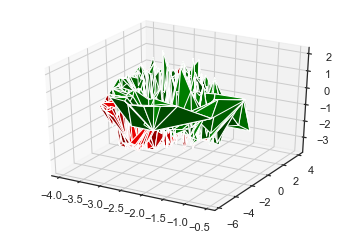

In [309]:
%matplotlib inline

ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z,color ='green')
ax.plot_trisurf(x2, y2, z2,color ='red')

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(img_scaled)
pcafeatures_train = pca.transform(img_scaled)
print(pca.explained_variance_ratio_)

[0.67550978 0.12244911]


In [17]:
pca_trans = pd.DataFrame(pcafeatures_train, columns = ['PC1', 'PC2'])

In [18]:
img_df_pca = img_df.join(pca_trans)

In [340]:
table1 = img_df_pca.groupby('cell_type').mean().reset_index()

In [341]:
table1

,cell_type,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,...,texture7,texture8,texture9,texture10,texture11,texture12,texture13,y,PC1,PC2
0,ADIPOSE,13.819914,0.019328,0.022735,-7.220487,-22.837938,-29.910376,-30.412646,0.335270,0.327396,...,3028.830745,5.523605,7.454153,0.001025,2.879838,-0.399141,0.983432,0,4.023091,-1.806393
1,COMPLEX,44.212923,0.220235,0.760909,-6.383838,-19.862369,-25.915288,-26.590410,0.340364,0.218537,...,5898.819959,8.100258,12.725810,0.000148,5.072140,-0.219323,0.974862,0,-2.226989,0.977505
2,DEBRIS,43.142938,0.134478,0.433980,-6.735249,-20.305314,-26.825382,-27.336742,0.321382,0.260891,...,7512.693050,8.010169,12.349908,0.000184,4.867983,-0.248874,0.978162,0,-1.029691,-0.435124
3,EMPTY,2.793015,0.000382,0.000780,-7.280509,-29.844256,-36.656374,-37.405215,0.333313,0.333657,...,102.404246,3.039739,3.645018,0.002235,1.222371,-0.439035,0.923333,0,8.515492,0.952547
4,LYMPHO,37.121886,0.236181,0.851858,-6.056418,-18.883743,-24.310584,-25.338248,0.379977,0.214241,...,8267.496921,7.989596,12.440579,0.000158,5.166090,-0.228385,0.976476,0,-2.938731,0.475946
5,MUCOSA,35.353453,0.185962,0.623963,-6.494953,-18.372150,-24.798703,-24.844439,0.363501,0.250179,...,10633.291341,8.492069,12.975929,0.000158,5.006302,-0.274323,0.990630,0,-2.294073,-1.353211
6,STROMA,47.249169,0.143861,0.640443,-6.581201,-20.696235,-26.927167,-27.633179,0.323546,0.232852,...,5599.321636,7.836361,12.248256,0.000209,4.826520,-0.221762,0.967741,0,-1.306637,0.883975
7,TUMOR,36.388780,0.236683,0.872034,-6.132627,-17.706310,-23.594984,-24.152410,0.376096,0.212010,...,8190.216583,7.858223,12.128012,0.000197,4.793895,-0.242796,0.976944,1,-2.742461,0.304755


In [337]:
table2 = img_df_pca.groupby('cell_type').std()

In [21]:
img_df_pca.groupby('y').mean()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,PC1,PC2
y,,,,,,,,,,,,,,,,,,,,,
0,31.956185,0.134347,0.476381,-6.678951,-21.543144,-27.906268,-28.508697,0.342479,0.262536,0.394985,...,291.556885,5863.265414,6.998828,10.548522,0.000588,4.148749,-0.290120,0.970662,0.391780,-0.043536
1,36.388780,0.236683,0.872034,-6.132627,-17.706310,-23.594984,-24.152410,0.376096,0.212010,0.411894,...,155.207838,8190.216583,7.858223,12.128012,0.000197,4.793895,-0.242796,0.976944,-2.742461,0.304755


In [23]:
img_df_pca.columns

Index(['cell_type', 'cell_type_idx', 'image_name', 'image_color',
       'edges_ratio', 'binary_ratio', 'moment1', 'moment2', 'moment3',
       'moment4', 'b_ratio', 'g_ratio', 'r_ratio', 'texture1', 'texture2',
       'texture3', 'texture4', 'texture5', 'texture6', 'texture7', 'texture8',
       'texture9', 'texture10', 'texture11', 'texture12', 'texture13', 'y',
       'PC1', 'PC2'],
      dtype='object')

In [24]:
X = img_df_pca.loc[:,'image_color': 'PC2']
X = X.drop(columns = ['y'])
y = img_df_pca['y']

In [25]:
X.head()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,PC1,PC2
0,37.381346,0.271778,0.930133,-6.073384,-17.710993,-22.952445,-23.463140,0.367143,0.200825,0.432032,...,146.451751,4934.987736,7.798934,12.328715,0.000160,4.937310,-0.201992,0.966400,-2.911103,1.458366
1,25.774205,0.263956,0.983600,-5.757911,-16.662870,-22.268695,-24.177842,0.447490,0.199853,0.352657,...,111.648998,2337.480936,7.266160,11.326210,0.000230,4.437029,-0.206366,0.959834,-2.313867,1.589461
2,38.188592,0.240622,0.901333,-6.096181,-16.430853,-24.992701,-23.808326,0.387388,0.207368,0.405244,...,155.854145,5755.463773,8.046597,12.503275,0.000166,4.910681,-0.234884,0.980374,-2.823205,0.617475
3,43.204986,0.255111,0.958400,-6.024287,-17.085305,-30.175906,-25.998352,0.346358,0.178513,0.475129,...,135.950386,3251.260150,7.711438,12.121164,0.000184,4.807944,-0.206450,0.966795,-2.396854,2.476390
4,34.589645,0.253600,0.900356,-6.159041,-17.927785,-23.518995,-23.914664,0.400556,0.215776,0.383668,...,155.883556,5021.716148,7.927546,12.417574,0.000164,4.950199,-0.219488,0.974709,-2.619360,0.768848


In [27]:
X.describe()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4,b_ratio,g_ratio,r_ratio,...,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,PC1,PC2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03
mean,32.510260,0.147139,0.525838,-6.610660,-21.063539,-27.367357,-27.964161,0.346681,0.256220,0.397099,...,274.513254,6154.134310,7.106252,10.745958,0.000539,4.229392,-0.284205,0.971448,-6.163958e-16,5.102196e-16
std,16.678986,0.095428,0.362081,0.467732,4.012780,4.320620,4.406501,0.030553,0.052456,0.056214,...,126.799810,4717.913273,1.823150,3.262851,0.000727,1.384140,0.091347,0.024324,3.942059e+00,1.678360e+00
min,1.622369,0.000000,0.000000,-7.288842,-38.428451,-45.539869,-43.511983,0.169033,0.135841,0.328928,...,71.585067,1.854839,1.667837,1.825923,0.000080,0.528850,-0.639531,0.861822,-3.942095e+00,-5.758618e+00
25%,21.567905,0.036311,0.055556,-7.111469,-22.256107,-28.818669,-29.530682,0.333132,0.214368,0.341674,...,176.279481,2714.703981,6.882303,10.289661,0.000141,3.905616,-0.333402,0.965633,-2.635601e+00,-1.398814e+00
50%,36.228094,0.179844,0.639333,-6.544643,-20.042269,-26.240665,-26.920028,0.340130,0.247627,0.391351,...,229.660834,5526.054967,7.930534,12.326177,0.000178,4.843921,-0.252231,0.979222,-1.937661e+00,-2.212704e-02
75%,42.337896,0.228889,0.844944,-6.268136,-18.386116,-24.437544,-24.926967,0.363393,0.315917,0.433779,...,408.379189,9142.538844,8.289094,12.869003,0.000482,5.125091,-0.218772,0.988373,1.591459e+00,1.272558e+00
max,74.879029,0.311422,0.999911,-5.346521,-13.942401,-19.463753,-20.088097,0.447490,0.335409,0.664399,...,487.786645,32556.398469,8.738704,13.575512,0.003268,5.797473,-0.119227,0.998471,1.152990e+01,5.945421e+00


In [28]:
X.columns

Index(['image_color', 'edges_ratio', 'binary_ratio', 'moment1', 'moment2',
       'moment3', 'moment4', 'b_ratio', 'g_ratio', 'r_ratio', 'texture1',
       'texture2', 'texture3', 'texture4', 'texture5', 'texture6', 'texture7',
       'texture8', 'texture9', 'texture10', 'texture11', 'texture12',
       'texture13', 'PC1', 'PC2'],
      dtype='object')

In [88]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: y, dtype: int64

#### scaling data

In [97]:
ssX = StandardScaler()
X_scaled = ssX.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = ['image_color','edges_ratio', 'binary_ratio', 'moment1', 'moment2', 'moment3','moment4'])

In [99]:
X_scaled_df.describe()

,image_color,edges_ratio,binary_ratio,moment1,moment2,moment3,moment4
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.514344e-16,2.618616e-15,2.713385e-16,-1.286526e-15,-2.405187e-16,-1.639222e-15,5.963230e-16
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.852090e+00,-1.542037e+00,-1.452409e+00,-1.450081e+00,-4.327835e+00,-4.206417e+00,-3.528736e+00
25%,-6.561219e-01,-1.161491e+00,-1.298960e+00,-1.070825e+00,-2.972221e-01,-3.359372e-01,-3.555379e-01
50%,2.229276e-01,3.427601e-01,3.134848e-01,1.411583e-01,2.545300e-01,2.607970e-01,2.369767e-01
75%,5.892816e-01,8.567534e-01,8.814003e-01,7.323821e-01,6.672908e-01,6.781679e-01,6.893221e-01
max,2.540503e+00,1.721715e+00,1.309432e+00,2.702971e+00,1.774792e+00,1.829459e+00,1.787553e+00


#### PCA

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X)
pcafeatures_X = pca.transform(X)
print(pca.explained_variance_ratio_)

[0.92977884 0.05912544 0.00556059 0.00517779]


In [105]:
pcafeatures_X_df = pd.DataFrame(pcafeatures_X, columns = ['PC1','PC2', 'PC3', 'PC4'])

In [106]:
pcafeatures_X_df.head()

,PC1,PC2,PC3,PC4
0,6.946575,-5.144664,-0.239176,-0.583302
1,-3.833954,-9.472531,1.067048,-0.261532
2,7.471945,-4.221271,-0.483399,1.733962
3,10.665750,1.848156,-1.484545,4.734877
4,4.070874,-5.376310,-0.227207,-0.361433


In [107]:
from sklearn.decomposition import PCA
pca_sca = PCA(n_components=4)
pca_sca.fit(X_scaled)
pcafeatures_X_sca = pca_sca.transform(X_scaled)
print(pca_sca.explained_variance_ratio_)

[0.81849548 0.07795419 0.04995996 0.02124341]


In [108]:
pcafeatures_X_sca_df = pd.DataFrame(pcafeatures_X_sca, columns = ['PC1','PC2', 'PC3', 'PC4'])

In [109]:
pcafeatures_X_sca_df.head()

,PC1,PC2,PC3,PC4
0,-2.568591,-0.322977,-0.613879,-0.204612
1,-2.706389,-0.571189,-1.479913,0.095460
2,-2.319383,-0.177117,-0.483805,-0.018441
3,-1.883882,-1.013492,0.063138,-0.079584
4,-2.225546,-0.256250,-0.654187,-0.158326


### LR models

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=193, stratify = y)

In [30]:
X_train.columns

Index(['image_color', 'edges_ratio', 'binary_ratio', 'moment1', 'moment2',
       'moment3', 'moment4', 'b_ratio', 'g_ratio', 'r_ratio', 'texture1',
       'texture2', 'texture3', 'texture4', 'texture5', 'texture6', 'texture7',
       'texture8', 'texture9', 'texture10', 'texture11', 'texture12',
       'texture13', 'PC1', 'PC2'],
      dtype='object')

In [31]:
conf_mat, lr = test_logistic(X_train, y_train, X_test, y_test)

Simple Logistic Regression(lr); Train F1: 0.578, Train AUC: 0.942
Simple Logistic Regression(lr); Test F1: 0.584, Test AUC: 0.934


In [32]:
conf_mat

array([[1265,   48],
       [  90,   97]])

In [139]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, lr.predict(X_test)))
print(classification_report(y_test, lr.predict(X_test)))

ROC_AUC: 0.741
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1313
           1       0.67      0.52      0.58       187

   micro avg       0.91      0.91      0.91      1500
   macro avg       0.80      0.74      0.77      1500
weighted avg       0.90      0.91      0.90      1500



In [33]:
conf_mat_os, lr_os = test_logistic_oversampling(X_train, y_train, X_test, y_test)

Logistic Regression CV on Oversampled Train Data(lr_os); Train F1: 0.655, Train AUC: 0.956
Logistic Regression CV on Oversampled Train Data(lr_os); Test F1: 0.640, Test AUC: 0.946


In [34]:
conf_mat_os

array([[1145,  168],
       [  20,  167]])

In [140]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, lr_os.predict(X_test)))
print(classification_report(y_test, lr_os.predict(X_test)))

ROC_AUC: 0.883
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1313
           1       0.50      0.89      0.64       187

   micro avg       0.87      0.87      0.87      1500
   macro avg       0.74      0.88      0.78      1500
weighted avg       0.92      0.87      0.89      1500



In [38]:
conf_mat_smote, lr_smote = test_logistic_smote(X_train, y_train, X_test, y_test)

Logistic Regression on SMOTE Train Data(lr_smote); Train F1: 0.679, Train AUC: 0.957
Logistic Regression on SMOTE Data(lr_smote); Test F1: 0.653, Test AUC: 0.948


In [141]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, lr_smote.predict(X_test)))
print(classification_report(y_test, lr_smote.predict(X_test)))

ROC_AUC: 0.881
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1313
           1       0.52      0.88      0.65       187

   micro avg       0.88      0.88      0.88      1500
   macro avg       0.75      0.88      0.79      1500
weighted avg       0.92      0.88      0.90      1500



In [39]:
conf_mat_us, lr_RUS = test_logistic_undersampling(X_train, y_train, X_test, y_test)

Logistic Regression on Undersampled Train Data(lr_RUS); Test F1: 0.638, Test AUC: 0.944


In [40]:
conf_mat__fac, conf_mat_bal, lr_bal, lr_fac = test_logistic_weights(X_train, y_train, X_test, y_test)

Balanced class weights Logistic Regression(lr_balanced) Test F1: 0.574, Test AUC: 0.926


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3:1 class weights Logistic Regression(lr_factorx) Test F1: 0.641, Test AUC: 0.946


In [41]:
def make_roc_curve(list_of_models):
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    for model in list_of_models:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr,lw=2)

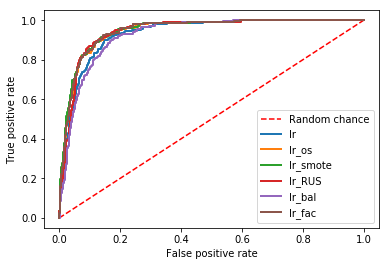

In [42]:
make_roc_curve([lr, lr_os, lr_smote, lr_RUS, lr_bal, lr_fac])
plt.legend(('Random chance','lr', 'lr_os', 'lr_smote', 'lr_RUS', 'lr_bal', 'lr_fac'));

In [333]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

In [334]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, lr_os.predict_proba(X_test)[:,1])

ROC AUC score =  0.9613368576676672


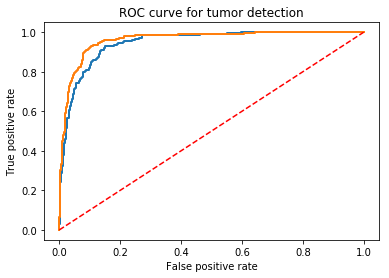

In [335]:
plt.plot(fpr, tpr,lw=2)
plt.plot(fpr1, tpr1,lw=2)
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for tumor detection');
print("ROC AUC score = ", roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1]))

In [43]:
log_loss(y_test, lr.predict_proba(X_test))

0.20316655366855696

In [44]:
log_loss(y_test, lr_os.predict_proba(X_test))

0.29123337930126636

### Naive Bayes

In [53]:
nb_g = GaussianNB()
nb_g.fit(X_train, y_train)
nb_g.score(X_test, y_test)


0.664

In [54]:
y_pred = nb_g.predict(X_train)
print("Number of mislabeled points out of a total %d points : %d"
    % (X_train.shape[0],(y_train != y_pred).sum()))

Number of mislabeled points out of a total 3500 points : 1140


In [358]:
nb_g.theta_

array([[ 3.19304525e+01,  1.33750548e-01,  4.75043791e-01,
        -6.68158547e+00, -2.15315534e+01, -2.79224225e+01,
        -2.85070855e+01,  3.42139700e-01,  2.62700932e-01,
         3.95159368e-01,  3.33226362e-02,  2.33985639e+02,
         8.98574015e-01,  1.51700876e+03,  2.83653224e-01,
         2.92245130e+02,  5.83404941e+03,  6.98935355e+00,
         1.05308072e+01,  5.91174385e-04,  4.14146728e+00,
        -2.90601778e-01,  9.70595106e-01,  4.09837867e-01,
        -3.94625250e-02],
       [ 3.64862278e+01,  2.37099340e-01,  8.71511213e-01,
        -6.13535579e+00, -1.77177145e+01, -2.35811525e+01,
        -2.42116026e+01,  3.75331350e-01,  2.12150128e-01,
         4.12518522e-01,  6.18640607e-04,  2.45673682e+02,
         9.21139209e-01,  2.13639459e+03,  1.31398306e-01,
         1.55209008e+02,  8.29990470e+03,  7.85856183e+00,
         1.21324132e+01,  1.96570657e-04,  4.80261396e+00,
        -2.42400877e-01,  9.76715823e-01, -2.75124187e+00,
         3.02125715e-01]])

In [55]:
print("Accuracy: %.3f"% accuracy_score(y_test, nb_g.predict(X_test)))
print(classification_report(y_test, nb_g.predict(X_test)))

Accuracy: 0.664
              precision    recall  f1-score   support

           0       1.00      0.62      0.76      1313
           1       0.27      0.98      0.42       187

   micro avg       0.66      0.66      0.66      1500
   macro avg       0.63      0.80      0.59      1500
weighted avg       0.90      0.66      0.72      1500



In [56]:
confusion_matrix(y_test, nb_g.predict(X_test))

array([[813, 500],
       [  4, 183]])

In [57]:
roc_auc_score(y_test, nb_g.predict_proba(X_test)[:,1])

0.9175053251931528

In [58]:
a = cross_validate(GaussianNB(), X_train, y_train, groups = y_train, \
               scoring ={'accuracy', 'f1', 'precision', 'recall', 'roc_auc'}, cv =10,\
              return_estimator = True)

In [59]:
a['test_accuracy'].mean()

0.6742944513832766

In [60]:
a['test_f1'].mean()

0.4272596357812065

In [61]:
a['test_precision'].mean()

0.27432901688527933

In [62]:
a['test_recall'].mean()

0.9680232558139534

In [63]:
a['test_roc_auc'].mean()

0.9268165401908055

In [51]:
a['estimator']

(GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09))

In [64]:
confusion_matrix(y_test, a['estimator'][0].predict(X_test))

array([[812, 501],
       [  4, 183]])

In [138]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, a['estimator'][0].predict(X_test)))
print(classification_report(y_test, a['estimator'][0].predict(X_test)))

ROC_AUC: 0.799
              precision    recall  f1-score   support

           0       1.00      0.62      0.76      1313
           1       0.27      0.98      0.42       187

   micro avg       0.66      0.66      0.66      1500
   macro avg       0.63      0.80      0.59      1500
weighted avg       0.90      0.66      0.72      1500



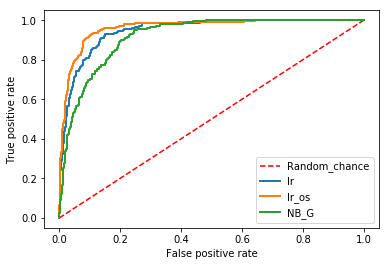

In [401]:
make_roc_curve([lr, lr_os, a['estimator'][0]])
plt.legend(('Random_chance', 'lr', 'lr_os', 'NB_G'))

In [65]:
log_loss(y_test, a['estimator'][0].predict_proba(X_test))

3.0007325362030626

Model best F1 score 0.516 at prob decision threshold >= 0.999


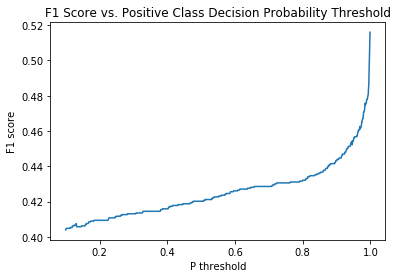

In [82]:
best_F1_finder(0.1, 0.999, a['estimator'][0])

In [66]:
def train_oversampling1(X_train, y_train, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = a//b
    ROS = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:a,1:b*factor}, \
                                               random_state=150) 
    
    X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)
    
    return X_tr_rs, y_tr_rs

In [67]:
X_tr_rs, y_tr_rs = train_oversampling1(X_train,y_train)

In [68]:
b = cross_validate(GaussianNB(), X_tr_rs, y_tr_rs, groups = y_tr_rs, \
               scoring ={'accuracy', 'f1', 'precision', 'recall', 'roc_auc'}, cv =10,\
              return_estimator = True)

In [69]:
b['test_accuracy'].mean()

0.7771597297223354

In [70]:
b['test_f1'].mean()

0.8034097520430062

In [71]:
b['test_precision'].mean()

0.6784098662654451

In [72]:
b['test_recall'].mean()

0.9851580413897194

In [73]:
b['test_roc_auc'].mean()

0.9228762738486316

In [74]:
confusion_matrix(y_test, b['estimator'][0].predict(X_test))

array([[774, 539],
       [  3, 184]])

In [137]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, b['estimator'][0].predict(X_test)))
print(classification_report(y_test, b['estimator'][0].predict(X_test)))

ROC_AUC: 0.787
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      1313
           1       0.25      0.98      0.40       187

   micro avg       0.64      0.64      0.64      1500
   macro avg       0.63      0.79      0.57      1500
weighted avg       0.90      0.64      0.70      1500



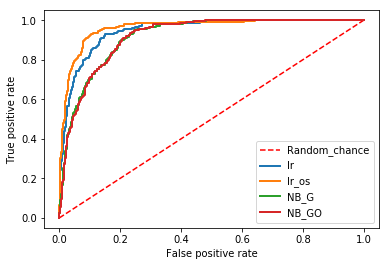

In [427]:
make_roc_curve([lr, lr_os, a['estimator'][0], b['estimator'][0]])
plt.legend(('Random_chance', 'lr', 'lr_os', 'NB_G', 'NB_GO'))

In [75]:
log_loss(y_test, b['estimator'][0].predict_proba(X_test))

3.587798102462612

Model best F1 score 0.421 at prob decision threshold >= 0.893


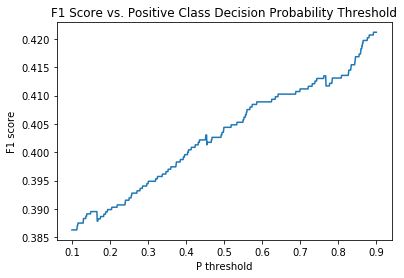

In [83]:
best_F1_finder(0.1, 0.9, b['estimator'][0])

### SVM

In [142]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

In [144]:
svc_l = LinearSVC(max_iter =7000, class_weight = 'balanced')
svc_l.fit(X_train,y_train)
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc_l.predict(X_test)))
print(classification_report(y_test, svc_l.predict(X_test)))

ROC_AUC: 0.560
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      1313
           1       0.57      0.13      0.22       187

   micro avg       0.88      0.88      0.88      1500
   macro avg       0.73      0.56      0.58      1500
weighted avg       0.85      0.88      0.85      1500



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [145]:
confusion_matrix(y_test, svc_l.predict(X_test))

array([[1294,   19],
       [ 162,   25]])

In [87]:
svc_l = cross_validate(LinearSVC(max_iter = 7000, class_weight = 'balanced'), X_train, y_train, groups = y_train, \
               scoring ={'accuracy', 'f1', 'precision', 'recall', 'roc_auc'}, cv =10,\
              return_estimator = True)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [146]:
param_grid = {'C': np.linspace(1e-7,1e2,11)}
grid = GridSearchCV(LinearSVC(max_iter = 7000, class_weight = 'balanced'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=7000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [147]:
svc = grid.best_estimator_
svc

LinearSVC(C=80.00000002, class_weight='balanced', dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=7000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [148]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc.predict(X_test)))
print(classification_report(y_test, svc.predict(X_test)))

ROC_AUC: 0.829
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1313
           1       0.31      0.96      0.47       187

   micro avg       0.73      0.73      0.73      1500
   macro avg       0.65      0.83      0.64      1500
weighted avg       0.91      0.73      0.77      1500



In [149]:
confusion_matrix(y_test, svc.predict(X_test))

array([[914, 399],
       [  7, 180]])

In [118]:
param_grid = {'C': np.linspace(1e-7,1e2,11), 'gamma' : (1e-7,1e-5,1e-3)}
grid = GridSearchCV(SVC(kernel = 'rbf'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02]), 'gamma': (1e-07, 1e-05, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [119]:
svc_rbf = grid.best_estimator_
svc_rbf

SVC(C=80.00000002, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [120]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc_rbf.predict(X_test)))
print(classification_report(y_test, svc_rbf.predict(X_test)))

ROC_AUC: 0.779
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1313
           1       0.70      0.59      0.64       187

   micro avg       0.92      0.92      0.92      1500
   macro avg       0.82      0.78      0.80      1500
weighted avg       0.91      0.92      0.91      1500



In [121]:
confusion_matrix(y_test, svc_rbf.predict(X_test))

array([[1265,   48],
       [  76,  111]])

In [122]:
param_grid = {'C': np.linspace(1e-7,1e2,11), 'gamma' : (1e-5,1e-3)}
grid = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02]), 'gamma': (1e-05, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [123]:
svc_rbf_bal = grid.best_estimator_
svc_rbf_bal

SVC(C=10.00000009, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [126]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc_rbf_bal.predict(X_test)))
print(classification_report(y_test, svc_rbf_bal.predict(X_test)))

ROC_AUC: 0.565
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1313
           1       0.57      0.14      0.23       187

   micro avg       0.88      0.88      0.88      1500
   macro avg       0.73      0.56      0.58      1500
weighted avg       0.85      0.88      0.85      1500



In [127]:
confusion_matrix(y_test, svc_rbf_bal.predict(X_test))

array([[1293,   20],
       [ 160,   27]])

In [128]:
param_grid = {'C': np.linspace(1e-7,1e2,11), 'gamma' : (1e-5,1e-3)}
grid = GridSearchCV(SVC(kernel = 'rbf'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_tr_rs, y_tr_rs)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02]), 'gamma': (1e-05, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [129]:
svc_rbf_os = grid.best_estimator_
svc_rbf_os

SVC(C=10.00000009, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [130]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc_rbf_os.predict(X_test)))
print(classification_report(y_test, svc_rbf_os.predict(X_test)))

ROC_AUC: 0.565
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1313
           1       0.57      0.14      0.23       187

   micro avg       0.88      0.88      0.88      1500
   macro avg       0.73      0.56      0.58      1500
weighted avg       0.85      0.88      0.85      1500



In [131]:
confusion_matrix(y_test, svc_rbf_os.predict(X_test))

array([[1293,   20],
       [ 160,   27]])

In [132]:
ssX= StandardScaler()
X_train_os_scaled = ssX.fit_transform(X_tr_rs)

In [133]:
param_grid = {'C': np.linspace(1e-7,1e2,11), 'gamma' : (1e-5,1e-3)}
grid = GridSearchCV(SVC(kernel = 'rbf'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train_os_scaled, y_tr_rs)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02]), 'gamma': (1e-05, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [134]:
svc_rbf_os_sc = grid.best_estimator_
svc_rbf_os_sc

SVC(C=90.00000001000001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, svc_rbf_os_sc.predict(X_test)))
print(classification_report(y_test, svc_rbf_os_sc.predict(X_test)))

ROC_AUC: 0.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1313
           1       0.12      1.00      0.22       187

   micro avg       0.12      0.12      0.12      1500
   macro avg       0.06      0.50      0.11      1500
weighted avg       0.02      0.12      0.03      1500



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
confusion_matrix(y_test, svc_rbf_os_sc.predict(X_test))

array([[   0, 1313],
       [   0,  187]])

In [512]:
param_grid = {'C': np.linspace(1e-7,1e2,11), 'gamma' : (1e-5,1e-3)}
grid = GridSearchCV(SVC(kernel = 'poly'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train_os_scaled, y_tr_rs)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-07, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
       8.e+01, 9.e+01, 1.e+02]), 'gamma': (1, 100.0, 1000.0, 100000.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [513]:
svc_poly_os_sc = grid.best_estimator_

In [514]:
print("Accuracy: %.3f"% accuracy_score(y_test, svc_poly_os_sc.predict(X_test)))
print(classification_report(y_test, svc_poly_os_sc.predict(X_test)))

Accuracy: 0.125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1313
           1       0.12      1.00      0.22       187

   micro avg       0.12      0.12      0.12      1500
   macro avg       0.06      0.50      0.11      1500
weighted avg       0.02      0.12      0.03      1500



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [515]:
confusion_matrix(y_test, svc_poly_os_sc.predict(X_test))

array([[   0, 1313],
       [   0,  187]])

### KNN

In [150]:
from sklearn.neighbors import KNeighborsClassifier



In [151]:
k_range = list(range(1, 100))

In [152]:
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


In [154]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='roc_auc')

In [155]:
grid.fit(X_train, y_train);

In [156]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8575793132824954
{'n_neighbors': 12}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')


In [157]:
# fit on train
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

In [159]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))

ROC_AUC: 0.566
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1313
           1       0.61      0.14      0.23       187

   micro avg       0.88      0.88      0.88      1500
   macro avg       0.75      0.57      0.58      1500
weighted avg       0.86      0.88      0.85      1500



In [160]:
confusion_matrix(y_test, knn.predict(X_test))

array([[1296,   17],
       [ 160,   27]])

In [161]:
knn_os = KNeighborsClassifier(n_neighbors=12)
knn_os.fit(X_tr_rs, y_tr_rs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

In [162]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, knn_os.predict(X_test)))
print(classification_report(y_test, knn_os.predict(X_test)))

ROC_AUC: 0.769
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      1313
           1       0.34      0.75      0.46       187

   micro avg       0.78      0.78      0.78      1500
   macro avg       0.65      0.77      0.66      1500
weighted avg       0.88      0.78      0.81      1500



In [163]:
confusion_matrix(y_test, knn_os.predict(X_test))

array([[1036,  277],
       [  47,  140]])

### dt

In [164]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [165]:
dt = DecisionTreeClassifier(class_weight = 'balanced')
dt.fit(X_train, y_train)

0.9473333333333334

In [166]:
confusion_matrix(y_test, dt.predict(X_test))

array([[1276,   37],
       [  42,  145]])

In [167]:
confusion_matrix(y_test, lr_os.predict(X_test))

array([[1145,  168],
       [  20,  167]])

In [169]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, dt.predict(X_test)))
print(classification_report(y_test, dt.predict(X_test)))

ROC_AUC: 0.874
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1313
           1       0.80      0.78      0.79       187

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.88      0.87      0.88      1500
weighted avg       0.95      0.95      0.95      1500



In [170]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, lr_os.predict(X_test)))
print(classification_report(y_test, lr_os.predict(X_test)))

ROC_AUC: 0.883
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1313
           1       0.50      0.89      0.64       187

   micro avg       0.87      0.87      0.87      1500
   macro avg       0.74      0.88      0.78      1500
weighted avg       0.92      0.87      0.89      1500



In [171]:
dt_os = DecisionTreeClassifier()
dt_os.fit(X_tr_rs, y_tr_rs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [172]:
confusion_matrix(y_test, dt_os.predict(X_test))

array([[1265,   48],
       [  40,  147]])

In [173]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, dt_os.predict(X_test)))
print(classification_report(y_test, dt_os.predict(X_test)))

ROC_AUC: 0.875
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1313
           1       0.75      0.79      0.77       187

   micro avg       0.94      0.94      0.94      1500
   macro avg       0.86      0.87      0.87      1500
weighted avg       0.94      0.94      0.94      1500



In [174]:
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, n_jobs=-1)
bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [175]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, bc.predict(X_test)))
print(classification_report(y_test, bc.predict(X_test)))

ROC_AUC: 0.893
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.95      0.79      0.87       187

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.96      0.89      0.92      1500
weighted avg       0.97      0.97      0.97      1500



In [176]:
confusion_matrix(y_test, bc.predict(X_test))

array([[1306,    7],
       [  39,  148]])

Model best F1 score 0.885 at prob decision threshold >= 0.420


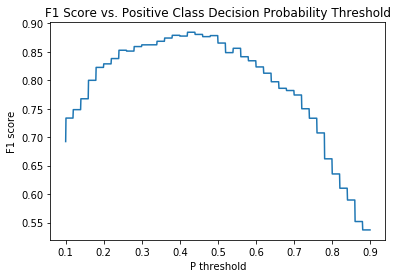

In [177]:
best_F1_finder(0.1, 0.9, bc)

In [178]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(bc, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [179]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr_os, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [180]:
param_grid = {'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]}

rfc = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier()), param_grid=param_grid)
rfc.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [182]:
bc_gs = rfc.best_estimator_
bc_gs

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=400, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [183]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, bc_gs.predict(X_test)))
print(classification_report(y_test, bc_gs.predict(X_test)))

ROC_AUC: 0.900
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       0.97      0.80      0.88       187

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.90      0.93      1500
weighted avg       0.97      0.97      0.97      1500



In [184]:
confusion_matrix(y_test, bc_gs.predict(X_test))

array([[1309,    4],
       [  37,  150]])

In [185]:
interactive(lambda threshold: make_confusion_matrix(bc_gs, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [186]:
rfc.fit(X_tr_rs, y_tr_rs)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [187]:
bc_os = rfc.best_estimator_
bc_os

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [188]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, bc_os.predict(X_test)))
print(classification_report(y_test, bc_os.predict(X_test)))

ROC_AUC: 0.906
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1313
           1       0.88      0.83      0.85       187

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.93      0.91      0.92      1500
weighted avg       0.96      0.96      0.96      1500



In [189]:
confusion_matrix(y_test, bc_os.predict(X_test))

array([[1291,   22],
       [  32,  155]])

In [190]:
interactive(lambda threshold: make_confusion_matrix(bc_os, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Rnd Forest

In [191]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]}

rfc1 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
rfc1.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [192]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, rfc1.predict(X_test)))
print(classification_report(y_test, rfc1.predict(X_test)))

ROC_AUC: 0.886
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       0.97      0.78      0.86       187

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.89      0.92      1500
weighted avg       0.97      0.97      0.97      1500



In [193]:
rfc1.fit(X_tr_rs, y_tr_rs)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [194]:
print("ROC_AUC: %.3f"% roc_auc_score(y_test, rfc1.predict(X_test)))
print(classification_report(y_test, rfc1.predict(X_test)))

ROC_AUC: 0.910
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1313
           1       0.93      0.83      0.88       187

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.95      0.91      0.93      1500
weighted avg       0.97      0.97      0.97      1500



In [195]:
confusion_matrix(y_test, rfc1.predict(X_test))

array([[1302,   11],
       [  32,  155]])

In [196]:
interactive(lambda threshold: make_confusion_matrix(rfc1, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [ ]:
log_loss(y_test, lr_os.predict_proba(X_test))

### Plotly graph

In [204]:
import plotly.plotly as py
import plotly.figure_factory as ff

data = (
  {"label": "KNN", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.34, 0.75],"point": [0.769]},
  {"label": "Naive Bayes", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.27,0.98], "point": [0.799]},
  {"label": "SVM Linear", "sublabel":"Score","range": [0.5, 0.75, 1.0],
   "performance": [0.31, 0.96],"point": [0.829]},
  {"label": "LR - OS", "sublabel": "Score",
   "range": [0.5, 0.75, 1.0], "performance": [0.37, 0.96], "point": [0.883]},
  {"label": "Decision Trees", "sublabel": "Score","range": [0.5, 0.75, 1.0],
   "performance": [0.72, 0.93], "point": [0.9]},
  {"label": "Random Forest", "sublabel": "Score","range": [0.5, 0.75, 1.0],
   "performance": [0.72, 0.96], "point": [0.9]}
)

fig = ff.create_bullet(
    data, titles='label', subtitles='sublabel', markers='point',
    measures='performance', ranges='range', orientation='v',
)
py.iplot(fig, filename='bullet chart of classification scores v')

In [200]:
data = (
  {"label": "LR - OS", "sublabel": "Score",
   "range": [0.5, 0.75, 1.0], "performance": [0.37, 0.96], "point": [0.883]},
  {"label": "Naive Bayes", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.27,0.98], "point": [0.799]},
  {"label": "SVM Linear", "sublabel":"Score","range": [0.5, 0.75, 1.0],
   "performance": [0.31, 0.96],"point": [0.829]},
  {"label": "KNN", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.34, 0.75],"point": [0.769]},
  {"label": "Decision Tree", "sublabel": "Score","range": [0.5, 0.75, 1.0],
   "performance": [0.72, 0.93], "point": [0.9]},
  {"label": "Random Forest", "sublabel": "Score","range": [0.5, 0.75, 1.0],
   "performance": [0.72, 0.96], "point": [0.9]}
)

fig = ff.create_bullet(
    data, titles='label', subtitles='sublabel', markers='point',
    measures='performance', ranges='range', orientation='h',
)
py.iplot(fig, filename='bullet chart of classification scores h')

In [369]:
data = (
  {"label": "Key", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.4, 0.75],"point": [0.8]},
  {"label": "Key", "sublabel": "Score", "range": [0.5, 0.75, 1.0],
   "performance": [0.4, 0.75],"point": [0.8]}
)

fig = ff.create_bullet(
    data, titles='label', subtitles='sublabel', markers='point',
    measures='performance', ranges='range', orientation='v',
)
py.iplot(fig, filename='bullet chart key')

### Gradient Boosting

In [210]:
import xgboost as xgb

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [211]:
accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

0.976

In [214]:
roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

0.9175012523876822

In [215]:
confusion_matrix(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

array([[1307,    6],
       [  30,  157]])

In [217]:
print(classification_report(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1313
           1       0.96      0.84      0.90       187

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.97      0.92      0.94      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:
{"label": "XG_Boost", "sublabel": "Score",
   "range": [0.5, 0.75, 1.0], "performance": [0.84, 0.96], "point": [0.92]}

In [363]:
interactive(lambda threshold: make_confusion_matrix(gbm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

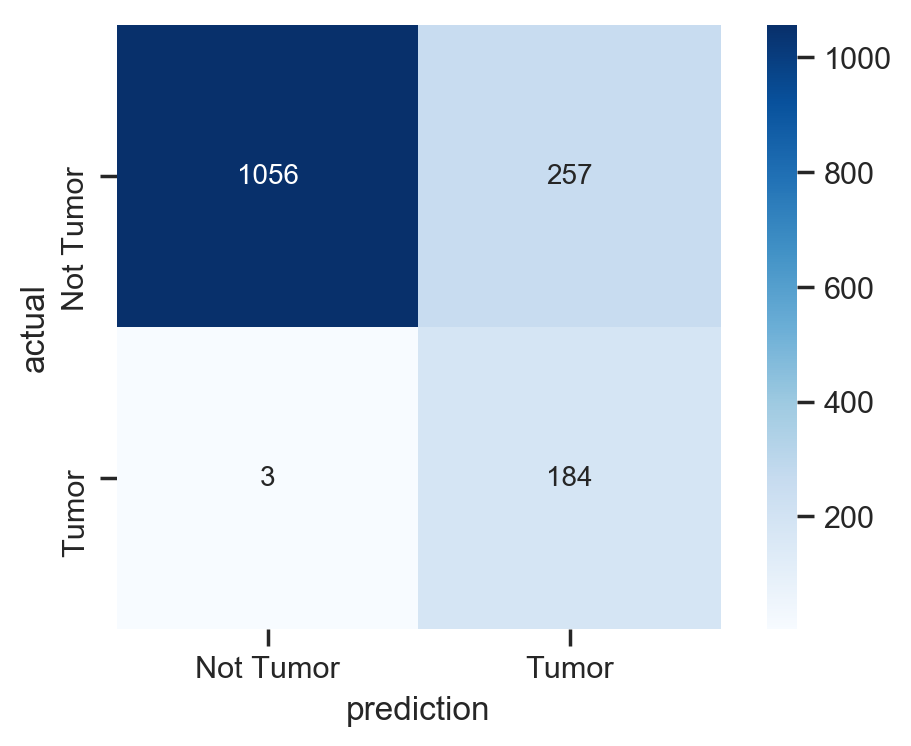

In [371]:
make_confusion_matrix(gbm, 0.01)
plt.xticks(rotation = 90)
#plt.savefig('final_confusion_matrix.png')

In [220]:
gbm1 = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.08, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm1.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

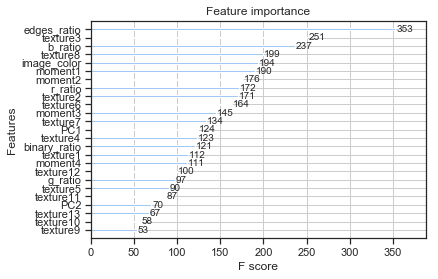

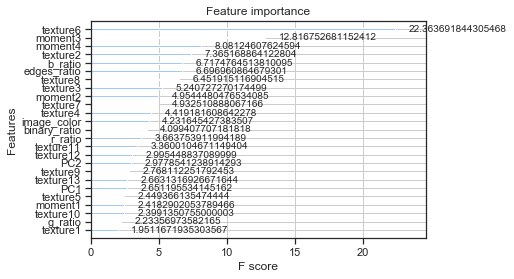

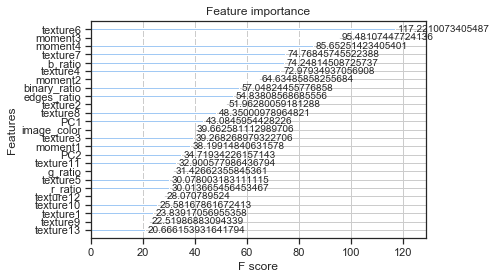

In [313]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')
xgb.plot_importance(gbm, importance_type='cover')

In [315]:
gbm_freq = gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores

In [325]:
gbm_freq_sort = sorted(gbm_freq.items(), key = lambda kv: kv[1], reverse = True)

In [326]:
gbm_freq_sort

[('edges_ratio', 353),
 ('texture3', 251),
 ('b_ratio', 237),
 ('texture8', 199),
 ('image_color', 194),
 ('moment1', 190),
 ('moment2', 176),
 ('r_ratio', 172),
 ('texture2', 171),
 ('texture6', 164),
 ('moment3', 145),
 ('texture7', 134),
 ('PC1', 124),
 ('texture4', 123),
 ('binary_ratio', 121),
 ('texture1', 112),
 ('moment4', 111),
 ('texture12', 100),
 ('g_ratio', 97),
 ('texture5', 90),
 ('texture11', 87),
 ('PC2', 70),
 ('texture13', 67),
 ('texture10', 58),
 ('texture9', 53)]

In [328]:
gbm_gain = gbm.get_booster().get_score(importance_type='gain')

In [329]:
gbm_gain

{'texture6': 22.363691844305468,
 'edges_ratio': 6.696960864679301,
 'texture2': 7.365168864122804,
 'texture13': 2.6631316926671644,
 'moment2': 4.9544480476534085,
 'b_ratio': 6.7174764513810095,
 'texture7': 4.932510888067166,
 'moment3': 12.816752681152412,
 'texture8': 6.451915116904515,
 'image_color': 4.231645427383507,
 'moment1': 2.4182902053789466,
 'texture12': 2.995448837089999,
 'texture3': 5.240727270174499,
 'texture4': 4.419181608642278,
 'texture9': 2.768112251792453,
 'r_ratio': 3.663753911994189,
 'moment4': 8.08124607624594,
 'PC1': 2.651195534145162,
 'binary_ratio': 4.099407707181818,
 'texture1': 1.9511671935303567,
 'texture5': 2.449366135474444,
 'texture11': 3.3600104671149404,
 'PC2': 2.9778541238914293,
 'texture10': 2.3991350755000003,
 'g_ratio': 2.23356973582165}